In [1]:
from css_utility_working import *

In [6]:
############################################################

In [15]:
def dev_conv(dev_file_path):
    """
    convert dev.tsv file to dataframe with restored sequence (original sequence)
    """
    dev_df=pd.read_csv(dev_file_path,sep="\t")
    dev_df.fillna(" ", inplace=True) # change the nan into empty string
    assert dev_df["sequence"].isnull().sum()==0, "check the dev file for nan values"
    
    def kmer2seq_or_space(seq):
        if seq == " ":
            return " "
        else:
            return kmer2seq(seq)
    
    dev_df["ori_seq"] = dev_df["sequence"].apply(kmer2seq_or_space)

    return dev_df

In [16]:
def get_matWcss(mat_path,dev_path):
    """
    Read atten.npy and dev.tsv to create two dictionaries:
        all_dict_1: attention matrix for label 1 per data strip
        all_dict_0: attention matrix for label 0 per data strip
    """
    atten_raw=np.load(mat_path)
    atten=pd.DataFrame(atten_raw)
    dev_raw=dev_conv(dev_path) #dev_conv is a function in css_utility
    dev=dev_raw[["ori_seq","label"]]
    dev.reset_index(drop=True, inplace=True)  # remove the header
    
    dev_label_1=dev[dev["label"]==1]
    dev_label_0=dev[dev["label"]==0]

    atten["label"] = dev["label"].values
    atten_label_1=atten[atten["label"]==1]
    dev_label_1.pop("label") # remove the label column
    atten_label_1.pop("label") # remove the label column
    atten_label_0=atten[atten["label"]==0]
    dev_label_0.pop("label") # remove the label column
    atten_label_0.pop("label") # remove the label column
    
    assert len(dev_label_1)==len(atten_label_1)
    assert len(dev_label_0)==len(atten_label_0)
    
    all_dict_1={i:(dev_label_1.loc[i], atten_label_1.loc[i]) for i in dev_label_1.index}
    all_dict_0={i:(dev_label_0.loc[i], atten_label_0.loc[i]) for i in dev_label_0.index}

    ### to use, apply following 
#     for index, (dev_entry, atten_entry) in list(atten_dict_1.items()):
#         dev_tar=dev_entry['ori_seq']
#         atten_tar=atten_entry.values
    
    return all_dict_1, all_dict_0

In [50]:
####################### draw the designated entry only ######################
def get_motifWScore(all_dict_1, motif="GBBBG", extend_len=0):   # modify the code for showing extended version
    """ 
    For a class of interest (labeled either 1 or 0, but normally 1), find the motif of interest with the corresponding attention scores.
    Outputs:
        - motif_found_all: a list of the list of found motif in the class of interest
        - score_found_all: a list of the list of corresponding scores (not normalized)
        - score_found_norm_all: a list of the list of corresponding scores (normalized, per each data strip)

    """
    #### small function to correctly show the counting number
    def get_ordinal_suffix(number):
        if 10 <= number % 100 <= 20:
            suffix = 'th'
        else:
            suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(number % 10, 'th')
        return suffix
    
    # all_dict_1 is the dictionary (key:index, value=tuple of motif and )
    motif_found_all=[]
    score_found_all=[]
    score_found_norm_all=[]

    cnt=0
    for index, (dev_entry, atten_entry) in list(all_dict_1.items()):
        dev_tar = dev_entry['ori_seq']
        atten = atten_entry.values.reshape(-1, 1).T  # Reshape to 2D array for heatmap
        atten_tar = atten[0] # atten is a list of list, with one element

#         if motif in dev_tar:
#             start_index=dev_tar.find(motif)
#             end_index=start_index+len(motif)
        if motif in dev_tar:
            start_index=dev_tar.find(motif)-extend_len
            end_index=start_index+len(motif)+(extend_len*2)
            if end_index <= len(atten_tar)+1:
                cnt+=1
                print(f"{motif}: {cnt}{get_ordinal_suffix(cnt)} appearance")
                print("- Index in attention matrix: ",index)
                print("- Score min-max: {} ~ {}".format(round(min(atten_tar),3), round(max(atten_tar),3)))
                motif_found=dev_tar[start_index:end_index]
                score_found=atten_tar[start_index:end_index].tolist()
                score_found_norm=[item/sum(atten_tar) for item in score_found]  # normalize
                
                motif_found_all.append(motif_found)
                score_found_all.append(score_found)
                score_found_norm_all.append(score_found_norm)

                ### create the motif figures 
                show_len=end_index-start_index
                fig_width=show_len*0.35
                
                ######## Data strip with colored scores (to show the motif on the colored strip)
                
                # plt.figure(figsize=(fig_width, 1))  # Adjusted height to give space for text
                # # Add colored text for each letter in dev_tar above the heatmap
                # for i, letter in enumerate(motif_found):                    
                #     plt.text(i + 0.5, -0.2, letter, color=state_col_dict.get(letter, 'black'),
                #              ha='center', va='center', fontsize=32, family='monospace')

                # sns.heatmap(data=[score_found], cmap="viridis", yticklabels=False, cbar=False)
                # plt.show()
    return motif_found_all, score_found_all, score_found_norm_all #list of list

In [51]:
mat_path="../database/ft_result/pred/4_gene_exp/test02_double_data/Ghexp_rpkm30_or_not/atten.npy"
dev_path="../database/fine_tune/gene_exp/4mer/Ghexp_rpkm30_or_not/tr_len_40k/dev.tsv"

In [52]:
def score2logo(motif_found_all, score_found_all, score_found_norm_all, norm=False):
    """
    Use the result of get_motifWScore, create logos
    """
    import logomaker
    num_row=len(motif_found_all[0])
    columns=[chr(i) for i in range(ord("A"), ord("O")+1)]
    
    # df for creating logo
    df_logo_all=[]
    df=pd.DataFrame(0.0, index=range(num_row), columns=columns)
    for i, motif_found in enumerate(motif_found_all):
        if norm:
            for j, letter in enumerate(motif_found):
                df.loc[j, letter]=round(score_found_norm_all[i][j],3)
        elif not norm:
            for j, letter in enumerate(motif_found):
                df.loc[j, letter]=round(score_found_all[i][j],3)   
        df_logo=df.copy()
        df_logo_all.append(df_logo)

        fig_width=num_row*0.5
        logo=logomaker.Logo(df_logo,color_scheme=state_col_dict_num, figsize=(fig_width,0.8))
        logo.style_spines(visible=False)
        logo.style_spines(spines=["left","bottom"], visible=True)
        plt.show()
    
    
    # Calculate the average
    total_df = pd.DataFrame()
    for df_logo in df_logo_all:
        total_df = total_df.add(df_logo, fill_value=0)
    average_df = total_df / len(df_logo_all)
    
    extracted_values = average_df.max(axis=1).tolist()   # make the average score into a list
    extracted_values = [round(item,3) for item in  extracted_values] 
    
    df_logo_all.append(average_df)
    
    print("---------- Average Score Motif Logo ----------")
    logo2=logomaker.Logo(average_df,color_scheme=state_col_dict_num, figsize=(fig_width+1,1))
    logo2.style_spines(visible=False)
    logo2.style_spines(spines=["left","bottom"], visible=True)
    plt.show()
#     print(average_df)
    logo_score = df_logo_all[-1].max(axis=1).tolist()
    logo_score = [round(item,3) for item in  extracted_values] 
    print("Average logo score:",logo_score)
    
    return logo_score 

In [53]:
def motif_logo(mat_path, dev_path, motif="GBBBG"):
    all_dict_1, all_dict_0=get_matWcss(mat_path,dev_path)
    motif_found_all,score_found_all,score_found_norm_all=get_motifWScore(all_dict_1, motif=motif)
    logo_score=score2logo(motif_found_all,score_found_all,score_found_norm_all)
    return

GBBBG: 1st appearance
- Index in attention matrix:  51
- Score min-max: 0.019 ~ 0.368
GBBBG: 2nd appearance
- Index in attention matrix:  539
- Score min-max: 0.01 ~ 0.268
GBBBG: 3rd appearance
- Index in attention matrix:  549
- Score min-max: 0.019 ~ 0.28


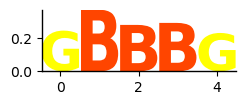

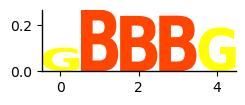

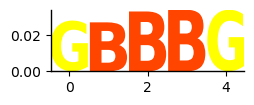

---------- Average Score Motif Logo ----------


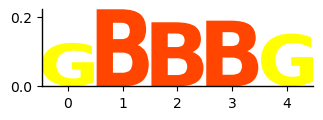

Average logo score: [0.125, 0.221, 0.184, 0.188, 0.151]


In [54]:

motif_logo(mat_path, dev_path, motif="GBBBG")

In [31]:
# test loading
path1="../database/remap2022/crm/lim10/E001_unitcss_limit_len10.pkl"
path2="../database/remap2022/crm/lim10/E002_unitcss_limit_len10.pkl"

with open(path1,"rb") as f:
    data1=pickle.load(f)

with open(path2,"rb") as g:
    data2=pickle.load(g)

In [42]:
len(data1[0])

29

In [61]:
# Cut if it is longer than 510
def css_CUT_Kmer(css, cut_thres=510, k=4):
    """ 
    A GENERAL version of `chr_css_CUT_Kmer` and updated to remove any nan in sequence
    Prepare kmer dataset for unit_css, as is if length<=510, else cut it to be length>510   
    Usage: css_CUT_Kmer(css, cut_thres, k)
    
    - css: unit-length css (e.g. comp_gene_css_all)
    - cut_thres: length of split, default=510
    - k: kmer
    
    Output: 1. splitted (before kmerization) 2. kmerized_unit_css (after kmerization) 
    """    
    splitted=[] # bucket for the all the splitted strings   
    for css_elm in css:
        if len(css_elm) <k:  # if the length of css_elm is shorter than k (cannot create k-mer)
            continue
        elif len(css_elm) <=cut_thres:
            splitted.append(css_elm)
        else:  
            prev=0
            while True:
                splitted.append(css_elm[prev:prev+cut_thres])
                prev+=cut_thres
                if prev>=len(css_elm)-1:
                    break      

    kmerized_unit_css_raw=[seq2kmer(item, k) for item in splitted] # k-merize here
    
    ### this part is updated to prevent any empty string to be generated ###
    kmerized_unit_css=[item for item in kmerized_unit_css_raw if item!=""]
    ########################################################################
    
    return splitted, kmerized_unit_css

In [56]:
def prep_by_merge_cell(input_path):  # css is the list of chromatin state sequence list in the region of interest
    """
    This function merges multiple .pkl data (unit-length of Chromatin state sequence, per cell) into one
    
    Output
    - A list of merged chromatin state sequences in the "input_path"
    """
    file_list=os.listdir(input_path)
    file_path_list=[os.path.join(input_path,file) for file in file_list]
    # print(file_path_list)
    
    def contains_sublists(input_list):
        # Check if any element in the list is a sublist (list type)
        return any(isinstance(element, list) for element in input_list)
    
    css_concat=[]
    for file_path in file_path_list:
        with open(file_path,"rb") as f:
            css=pickle.load(f)
        # if it contains a sublist, then flatten it (normally it does)
        # print(contains_sublists(css))
        if contains_sublists(css):
            
            css=flatLst(css)
        # print(type(css))
        css_concat.extend(css)  
    return css_concat

In [70]:
def kmerize_and_cut(input_path,output_path, output_file_name, k=4, cut_thres=510):
    """
    This function merges all the file under input_path, and cut if an entry is longer than cut_thres,
    and k-merize before save it at the output_path

    Parameters:
    - input_path: path to the chromatin state data in .pkl format
    - output_path: path to the output
    - output_file_name: desired file name.  e.g.) "output.txt"
    - k: desired number for k-merization, default=4
    - cut_thres: desired number for threshold for cutting long entries, default=510
    """
    css_mergerd=prep_by_merge_cell(input_path)
    _, kmerized_unit_css=css_CUT_Kmer(css_mergerd, cut_thres=cut_thres, k=k)
    # print(type(kmerized_unit_css))
    # print(len(kmerized_unit_css))
    # Open a text file for writing
    output_file_path=os.path.join(output_path,output_file_name)
    with open(output_file_path, 'w') as file:
        # Write each item on a new line
        for item in kmerized_unit_css:
            file.write(f"{item}\n")
    return print("The files in {} were merged, {}-merized, and saved at{}".format(input_path,k,output_path))

In [71]:
kmerize_and_cut(input_path="../database/test_box/input_test",output_path="../database/test_box/output_test/",
                output_file_name="test.txt", k=4, cut_thres=510)

The files in ../database/test_box/input_test were merged, 4-merized, and saved at../database/test_box/output_test/


In [57]:
css_concat=prep_by_merge_cell("../database/test_box/input_test/")

In [58]:
len(css_concat)

586

In [59]:
css_concat[0]

'AAAAAAABBF'

In [26]:
def process_save_TF(cl1_path, cl2_path, output_path, k=4, wo_cont_o_state=True, len_tr=20000, len_dev=1000):
    """
    When you have k-merized .txt file for each class, process and save it for fine-tuning data 

    Parameters:
    - cl1_path (str): Path to class 1 (the class of interest) 
    - cl2_path (str): Path to class 2 (the class of comparison)
    - output_path (str): Path to save the result file (train.tsv, dev.tsv)
    - k (int): The length of k-mer, default=4
    - wo_cnt_o_state (bool): whether to remove continuous O state (True to remove)
    - len_tr: The length of train.tsv file. Default=20000
    - len_dev: The length of dev.tsv file. Default=1000

    Output:
    - Fine-tuning data file named "train.tsv" and "dev.tsv" are saved at output_path

    """
    cl1=pd.read_csv(cl1_path, header=None, names=["sequence"])
    cl1_list=cl1["sequence"].tolist()
    cl2=pd.read_csv(cl2_path, header=None, names=["sequence"])
    cl2_list=cl2["sequence"].tolist()

    if wo_cont_o_state:
        cl1_list = [item for item in cl1_list if k*"O" not in item]
        cl2_list = [item for item in cl2_list if k*"O" not in item]
    
    print("class 1 has {} elements.".format(len(cl1_list)))
    print("class 2 has {} elements.".format(len(cl2_list)))

    # make it dataframe
    df_cl1=pd.DataFrame(cl1_list, columns=["sequence"])
    df_cl1["label"]=1
    df_cl2=pd.DataFrame(cl2_list, columns=["sequence"])
    df_cl2["label"]=0
    
    # make them have the same length
    if len(df_cl1)>len(df_cl2):
        df_cl1=df_cl1[:len(df_cl2)] 
    elif len(df_cl1)<len(df_cl2):
        df_cl2=df_cl2[:len(df_cl1)]
    assert len(df_cl1)==len(df_cl2), "Check the data length."
    
    # shuffling 
    df_all=pd.concat([df_cl1,df_cl2]).sample(frac=1).reset_index(drop=True)  

    # cutting into train and dev
    assert len(df_all)> len_tr+len_dev, "Not enough data length."
    df_train=df_all[:len_tr]
    df_dev=df_all[len_tr:len_tr+len_dev]    

    train_name=os.path.join(output_path,"train.tsv")
    dev_name=os.path.join(output_path,"dev.tsv")
    
    df_train.to_csv(train_name, sep="\t", index=False)
    df_dev.to_csv(dev_name, sep="\t", index=False)

    return print("Fine-tuning data are saved at {}.".format(output_path))


    

In [27]:
cl1_path="../database/pretrain/crm/lim10/crm_lim10_allcell_4merized.txt"
cl2_path="../database/pretrain/not_crm/lim10/not_crm_lim10_allcell_4merized.txt"
output_path="../database/fin_test"

In [28]:
process_save_TF(cl1_path=cl1_path, cl2_path=cl2_path, output_path=output_path, k=4, wo_cont_o_state=True, len_tr=20000, len_dev=1000)

class 1 has 31924 elements.
class 2 has 193277 elements.
Fine-tuning data are saved at ../database/fin_test.


In [ ]:
# general pipeline for fine-tuning dataset preparation
# When you have .pkl unit css files for target/ non_target by cell

def prep_and_saveTF(target_input_path="", off_target_input_path="",  cut_thres=510, k=4, output_path="",len_tr=20000, len_dev=1000):
    """
    prepare fine tuning data for target and off-target

    Parameters:
    - target_input_path (str): Path to the target input file directory (e.g. promoter regions)
    - off_target_input_path (str): Path to the off-target input file directory (e.g. non-promoter regions)
    - cut_thres (int):  The maximum length of the data, default=510
    - k (int): The length of k-mer, default=4
    - output_path (str): Path to the output directory
    - len_tr: The length of train.tsv file. Default=20000
    - len_dev: The length of dev.tsv file. Default=1000

    """
    target_files=os.listdir(target_input_path)
    off_target_files=os.listdir(off_target_input_path)

    target_file_path=[os.path.join(target_input_path, file) for file in target_files]
    off_target_file_path=[os.path.join(off_target_input_path, file) for file in off_target_files]

    target_css_list=[]
    for target_file in target_file_path:
        with open(target_file, "rb") as f:
            target_css=pickle.load(f)
        target_css=flatLst(target_css)
    target_css_list.append(target_css)
    _, target_css_kmer_list=css_CUT_Kmer(target_css_list, cut_thres=cut_thres, k=k)

    ##########################3



    
    


    print("* train: dev = {} : {}".format(len_tr,len_dev))
    
    comp_path="../database/temp_files/complexity/"+condition+"/comp"
    comp=pickle.load(open(comp_path, "rb"))
    Ngene_path="../database/temp_files/css_Ngene_unit_lst_all"
    Ngene=pickle.load(open(Ngene_path, "rb"))
    #flatten
    Ngene=flatLst(Ngene)
    
    # kmerization
    _, comp_kmerized=css_CUT_Kmer(comp, cut_thres=cut_thres, k)
    _, Ngene_kmerized=css_CUT_Kmer(Ngene, cut_thres=cut_thres, k)
    
    # make it dataframe
    df_comp=pd.DataFrame(comp_kmerized, columns=["sequence"])
    df_comp["label"]=1
    df_Ngene=pd.DataFrame(Ngene_kmerized, columns=["sequence"])
    df_Ngene["label"]=0
    
    # make them have the same length
    if len(df_comp)>len(df_Ngene):
        df_comp=df_comp[:len(df_Ngene)] 
    elif len(df_comp)<len(df_Ngene):
        df_Ngene=df_Ngene[:len(df_comp)]
    assert len(df_comp)==len(df_Ngene), "Check the data length."
    
    # shuffling ...
    df_compNgene=pd.concat([df_comp,df_Ngene]).sample(frac=1).reset_index(drop=True)  

    # cutting into train and dev
    assert len(df_compNgene)> len_tr+len_dev, "Not enough data length."
    df_compNgene_train=df_compNgene[:len_tr]
    df_compNgene_dev=df_compNgene[len_tr:len_tr+len_dev]    
  
    path="../database/fine_tune/"+save_path+"/"+str(k)+"mer/"
    train_name=path+"train.tsv"
    dev_name=path+"dev.tsv"
    
    df_compNgene_train.to_csv(train_name, sep="\t", index=False)
    df_compNgene_dev.to_csv(dev_name, sep="\t", index=False)

    return print("Fine-tuning data for {} are {}merized and saved at {}.".format(save_path,k,path))

In [ ]:
## create function for preparing the fine tuning, removing the continuous o options
## then add this to the file css_utility_working

def saveCRMforFT_by_cell(input_path="../database/remap2022/crm/",target_cell=[],output_path="../database/pretrain/crm/",limit_len=10, k=4): 
    
    files=os.listdir(os.path.join(input_path,"lim"+str(limit_len)))
    # filter the target files
    target_files= [file for file in files if any(substring in file for substring in target_cell)]
    css_all=[]
    for file in target_files:
        file_name=os.path.basename(file)
        if file_name[0] == 'E' and file_name[1:4].isdigit():
            file_id = file_name[:4]
        else:
            pass
        # ##########################
        # if str(file_id)=="E003":
        #     break  # for test
        # ##########################
        with open(os.path.join(input_path,"lim"+str(limit_len),file), "rb") as f:
            css_lst=pickle.load(f)
        css=flatLst(css_lst)
        css_kmer=[]
        for css_chr in css:
            css_chr_kmer=seq2kmer(css_chr,k)
            target_to_remove="O"*k   # get rid of the word with continuous 15th state "o"
            css_chr_kmer_trim = css_chr_kmer.replace(target_to_remove, "")
            # clean up extra spaces
            css_chr_kmer_trim = ' '.join(css_chr_kmer_trim.split())
            css_kmer.append(css_chr_kmer_trim)
        css_all.append(css_kmer)
    css_all_flt=flatLst(css_all)
    os.makedirs(os.path.join(output_path, "lim" + str(limit_len)), exist_ok=True)
    output_name="crm_lim"+str(limit_len)+"_allcell_wo_cnt_o"+str(k)+"merized.txt"
    with open(os.path.join(output_path,"lim"+str(limit_len),output_name), "w") as g:
            g.write("\n".join(css_all_flt))
    return print("File is saved at {}".format(output_path))

In [35]:
input_path="../database/remap2022/crm/"
limit_len=10
test_list=os.listdir(os.path.join(input_path,"lim"+str(limit_len)))
cell_list=["E001","E022","E129"]

filtered_filenames = [filename for filename in test_list if any(substring in filename for substring in cell_list)]
filtered_filenames


['E001_unitcss_limit_len10.pkl',
 'E022_unitcss_limit_len10.pkl',
 'E129_unitcss_limit_len10.pkl']

In [3]:
############################################################

In [51]:
def motif_init2pred(input_path="./init_concat.csv", categorical=False, fillna_method="ffill", n_clusters=11, linkage_method="complete"):
    """
    Read init.csv file and directly predict the class using DTW and Agglomerative Clustering.
    This version includes forward-reverse comparison.
    This version considers the difference in state as categorical if categorical=True.

    Parameters:
    - input_path (str): Path to the input CSV file.
    - categorical (bool): Whether to treat the data as categorical.
    - fillna_method (str or int): Method to fill missing values. Use "ffill" for forward fill or 0 to fill with zeros.
    - n_clusters (int): Number of clusters for Agglomerative Clustering.
    - linkage_method (str): Linkage method for Agglomerative Clustering. Options are "complete", "average", or "single".
    
    Returns:
    - dtw_distance_matrix (np.ndarray): DTW distance matrix.
    - y_pred (np.ndarray): Predicted cluster labels.

    """
    def dataframe_reverse_and_push_nan(df):
        # Reverse rows of each column except 'position'
        df_rev = df.loc[:, df.columns != 'position'].apply(lambda col: col[::-1].values, axis=0)
        # Add the 'position' column back without changing its order
        df_rev.insert(0, 'position', df['position'])
        # Reset row index to ensure continuous row index
        df_rev = df_rev.reset_index(drop=True)
        # Push NaN values to the end of each column except 'position'
        for col in df_rev.columns:
            if col != 'position':
                non_nan = df_rev[col].dropna()
                nan_count = df_rev[col].isna().sum()
                df_rev[col] = pd.concat([non_nan, pd.Series([pd.NA] * nan_count)], ignore_index=True)    
        return df_rev
    
    df_sequences = motif_init2df(input_path=input_path)
    # print(f"Initial number of entries: {len(df_sequences)}")  # Debug print

    if fillna_method not in [0, "ffill"]:
        raise ValueError("Invalid fillna_method. Use 0 or 'ffill'.")

    X_train = df_sequences.loc[:, df_sequences.columns != 'position']
    if fillna_method==0:
        X_train_filled = X_train.fillna(0)
    if fillna_method=="ffill":
        X_train_filled = X_train.fillna(method=fillna_method) 
    n_columns = X_train_filled.shape[1]
    # print(f"Number of entries after filling NaNs: {n_columns}")  # Debug print

    dtw_distance_matrix = np.zeros((n_columns, n_columns))

    df_sequences_rev = dataframe_reverse_and_push_nan(df_sequences)  # Reverse
    X_train_rev = df_sequences_rev.loc[:, df_sequences_rev.columns != 'position']
    if fillna_method==0:
        X_train_filled_rev = X_train_rev.fillna(0)
    if fillna_method=="ffill":
        X_train_filled_rev = X_train_rev.fillna(method=fillna_method) 
    # X_train_filled_rev = X_train_rev.fillna(fillna_method)  # Fill missing values with zero    

    def categorical_distance(a, b):
        return 0 if a == b else 1

    def dtw_categorical(seq1, seq2):
        n, m = len(seq1), len(seq2)
        dtw = np.full((n+1, m+1), np.inf)
        dtw[0, 0] = 0
        for i in range(1, n+1):
            for j in range(1, m+1):
                cost = categorical_distance(seq1[i-1], seq2[j-1])
                dtw[i, j] = cost + min(dtw[i-1, j],    # insertion
                                    dtw[i, j-1],    # deletion
                                    dtw[i-1, j-1])  # match
        return dtw[n, m]
    
    import time
    start_dtw = time.time()
    for i in range(n_columns):
        for j in range(i, n_columns):  # No need to compute the distance twice for (i, j) and (j, i)
            if categorical:
                distance_ff=dtw_categorical(X_train_filled.iloc[:, i].values, X_train_filled.iloc[:, j].values)  # Forward-forward
                distance_fr=dtw_categorical(X_train_filled.iloc[:, i].values, X_train_filled_rev.iloc[:, j].values)  # Forward-reverse
            else:
                distance_ff = dtw(X_train_filled.iloc[:, i].values, X_train_filled.iloc[:, j].values)  # Forward-forward
                distance_fr = dtw(X_train_filled.iloc[:, i].values, X_train_filled_rev.iloc[:, j].values)  # Forward-reverse

                # Select the minimum distance and assign symmetrically
            min_distance = min(distance_ff, distance_fr)
            dtw_distance_matrix[i, j] = min_distance
            dtw_distance_matrix[j, i] = min_distance
            
    end_dtw = time.time()
    print(f"DTW computation time: {end_dtw - start_dtw} seconds")

    # Measure time for clustering
    start_clustering = datetime.now()
    
    # Use Agglomerative Clustering with the precomputed DTW distance matrix
    # for linkage option, 
    # complete: mazimize the minimum distance between points in different clusters
    # average: uses the average distance between all points in the two clusters
    # single: minimize the distance between the closest points of the clusters
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage=linkage_method)
    y_pred = clustering.fit_predict(dtw_distance_matrix)
    
    end_clustering = datetime.now()
    print('Clustering Duration: {}'.format(end_clustering - start_clustering))
    
    print(f"Number of cluster labels: {len(y_pred)}")  # Debug print
    # return X_train_filled, X_train_filled_rev, y_pred
    return dtw_distance_matrix, y_pred
    

In [58]:
def motif_init2class(input_path="./init_concat.csv", categorical=False, fillna_method="ffill", n_clusters=11, linkage_method="complete"): #,fillna_method='ffill'):
    df_sequences=motif_init2df(input_path=input_path)

    # Transpose df_test so that each entry becomes a row
    df_seq_transposed = df_sequences.T  
    # The first row will likely contain something other than data (e.g., time points), so let's keep it as a header
    new_header = df_seq_transposed.iloc[0]  # Grab the first row for the header
    df_seq_transposed = df_seq_transposed[1:]  # Take the data less the header row
    df_seq_transposed.columns = new_header  # Set the header row as the df header
    # Reset the index to make the entries into a column
    df_seq_transposed.reset_index(inplace=True)
    # Rename the 'index' column to something more descriptive, like 'Entry'
    df_seq_transposed.rename(columns={'index': 'Entry'}, inplace=True)

    _, y_pred=motif_init2pred(input_path=input_path,categorical=categorical,fillna_method=fillna_method,  n_clusters=n_clusters, linkage_method=linkage_method)

    # Add the cluster labels as a new column
    df_seq_transposed['Cluster'] = y_pred
    # Sort the DataFrame by the 'Cluster' column
    df_sorted_by_cluster = df_seq_transposed.sort_values(by='Cluster')
    # Reset the index of the sorted DataFrame
    df_sorted_by_cluster.reset_index(drop=True, inplace=True)
    # Display the sorted DataFrame
    # df_sorted_by_cluster
    # Reverse the letter_to_num mapping
    letter_to_num = {'A': 1,'B': 2,'C': 3,'D': 4,'E': 5,'F': 6,'G': 7,
                        'H': 8,'I': 9,'J': 10,'K': 11,'L': 12,'M': 13,'N': 14,'O': 15}
    num_to_letter = {v: k for k, v in letter_to_num.items()}

    # Function to convert a series of numbers to a letter string, ignoring NaNs
    def series_to_letters(series):
        return ''.join([num_to_letter.get(x, '') for x in series if pd.notna(x)])

    # Apply the conversion to each row (excluding the 'Cluster' column) and add the result to a new column
    df_sorted_by_cluster['LetterSequence'] = df_sorted_by_cluster.drop('Cluster', axis=1).apply(series_to_letters, axis=1)

    # Group by 'Cluster' and aggregate 'LetterSequence' into lists
    clustered_sequences = df_sorted_by_cluster.groupby('Cluster')['LetterSequence'].apply(list).reset_index()

    # Display the result
    return clustered_sequences

In [21]:
def motif_init2cluster_vis(input_path="./init_concat.csv", categorical=False, n_clusters=11, fillna_method="ffill", linkage_method="complete", random_state=95, font_scale=0.004,font_v_scale=9, fig_w=12, fig_h=8, node_size=1000, node_dist=0.05):
    clustered_sequences=motif_init2class(input_path=input_path, categorical=categorical, fillna_method=fillna_method, n_clusters=n_clusters, linkage_method=linkage_method)
    scale_factor = font_scale  # Adjust this to change the font size

    def create_text_patch(x, y, text, state_col_dict_num, ax, scale_factor):
        # Determine the starting x position for the first letter
        x_offset = x
        for letter in text:
            color = state_col_dict_num.get(letter, (0, 0, 0))
            # fp = FontProperties(family="Arial", weight="bold")
            fp = FontProperties(family="DejaVu Sans", weight="bold")
            tp = TextPath((0, 0), letter, prop=fp)
            tp_transformed = transforms.Affine2D().scale(scale_factor).translate(x_offset, y) + ax.transData
            letter_patch = PathPatch(tp, color=color, lw=0, transform=tp_transformed)
            ax.add_patch(letter_patch)
            # Get the width of the letter and add a small margin
            letter_width = tp.get_extents().width * scale_factor
            x_offset += letter_width  # Increment the x position by the width of the letter

    df = clustered_sequences

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))  # Adjust figure size as needed
    
    ##### color modification for temporary use #####
    # Create a temporary copy with a different name
    temp_state_col_dict_num = state_col_dict_num.copy()

    # Modify the colors in the temporary dictionary
    # Update 'G' to a more visible color, such as a deep orange
    temp_state_col_dict_num['G'] = (1.0, 0.647, 0.0)  # Normalized deep orange

    # Update 'O' to ensure it stands out more, such as a darker gray
    temp_state_col_dict_num['O'] = (0.502, 0.502, 0.502)  # Normalized darker gray

    ################################################

    # Create a graph
    G = nx.Graph()
    for index, row in df.iterrows():
        G.add_node(row['Cluster'], elements=row['LetterSequence'])

    # Significantly increase the base size for each node
    base_node_size = node_size  # This increases the node size
    node_sizes = [len(elements) * base_node_size for elements in df['LetterSequence']]

    # Generate a color palette with a unique color for each node
    colors = plt.cm.rainbow(np.linspace(0, 1, len(df)))

    np.random.seed(random_state)
    # Draw the graph with a spring layout
    # Adjust k to manage the distance between nodes, which can be smaller since nodes can overlap
    pos = nx.spring_layout(G, k=node_dist, iterations=10)

    # Draw the nodes themselves
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=colors, alpha=0.3)

    # Draw the text
    for node, (node_pos, elements) in enumerate(zip(pos.values(), df['LetterSequence'])):      
        x_start, y_start = node_pos
        for i, element in enumerate(elements):
            x_position = x_start - 0.08
            y_position = y_start - (i * scale_factor * font_v_scale) + 0.015*len(elements)# Adjust line spacing
            create_text_patch(x_position, y_position, element, temp_state_col_dict_num, ax, scale_factor)
#             print("state_col_dict_num", state_col_dict_num)

    plt.axis('off')
    print(n_clusters)
    plt.show()
    
    fig.savefig("./cluster_result.png",bbox_inches='tight', dpi=300,facecolor='white',  # Set the background color to white 
    edgecolor='black')

DTW computation time: 4.7872397899627686 seconds
Clustering Duration: 0:00:00.001254
Number of cluster labels: 116
11


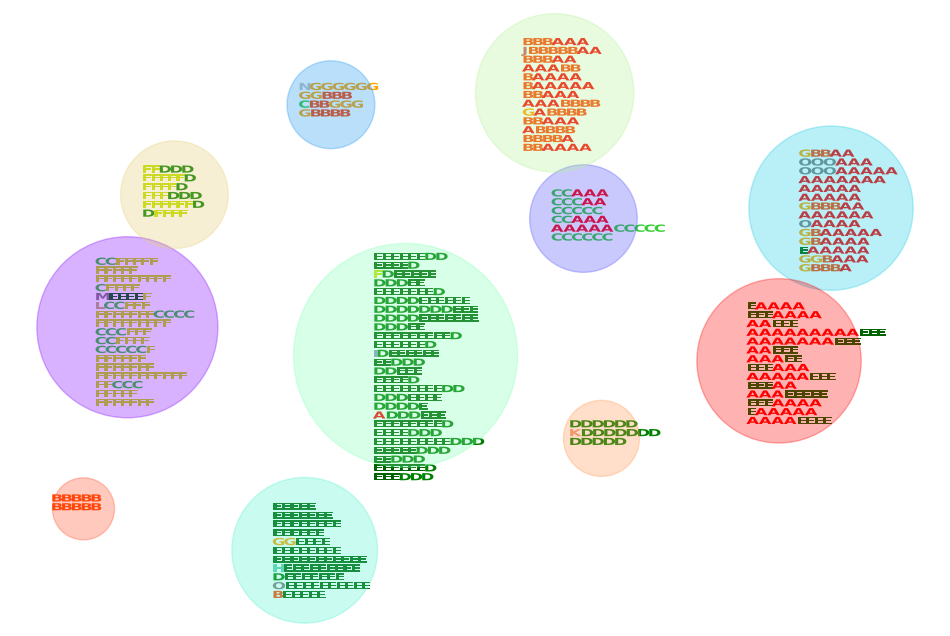

In [20]:
motif_init2cluster_vis(categorical=True, random_state=82, node_size=1000, fig_w=12, fig_h=8)

In [17]:
# for i in [13,41,82]:
#     print("randome_state=", i)
#     motif_init2cluster_vis(categorical=True, random_state=i, node_size=1000, fig_w=12, fig_h=8)

In [30]:
def motif_init2umap(input_path="./init_concat.csv",categorical=False,  n_clusters=11, fillna_method="ffill", n_neighbors=5, min_dist=0.3, random_state=2):
    """
    Generate a UMAP embedding of the given data.

    Parameters:

    - input_path: .csv file of all motifs with high attention score
    
    - n_clusters: number of clusters

    - n_neighbors: int (default=5), The size of local neighborhood (in terms of number of neighboring sample points) 
      used for manifold approximation. Larger values result in a more global view of the manifold, while smaller values emphasize local data structures. 
      Adjust according to the desired granularity of the embedding.
      
    - mid_dist: float (default=0.3), The minimum distance between embedded points in the low-dimensional space. 
      Smaller values allow points to cluster more tightly in the embedding, which is useful for identifying finer substructures within the data. 
      Larger values help preserve the overall topology of the data by preventing points from clustering too tightly.
    """
    df_sequences = motif_init2df(input_path=input_path)
    X_train = df_sequences.loc[:, df_sequences.columns != 'position']
    X_train = X_train.astype('float64')  # Convert to float64
    # X_filled = X_train.fillna(X_train.mean())
    if fillna_method==0:
        X_train_filled = X_train.fillna(0)
    if fillna_method=="ffill":
        X_train_filled = X_train.fillna(method=fillna_method) 

    dtw_distance_matrix, y_pred = motif_init2pred(input_path=input_path, categorical=categorical, n_clusters=n_clusters, fillna_method=fillna_method)

    # Now apply UMAP on the cleaned data
    from umap import UMAP
    # # seed=111
    # # umap_reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=seed)
    # umap_reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist)
    umap_reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state, n_jobs=1)

    # umap_embedding = umap_reducer.fit_transform(X_train_filled.T)  # Ensure the data is transposed if necessary
    umap_embedding = umap_reducer.fit_transform(dtw_distance_matrix)  # Ensure the data is transposed if necessary

    plt.figure(figsize=(8, 5))
    scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=y_pred, cmap='Spectral', s=100, edgecolors='gray', linewidth=0.6)

    # Create a color bar with ticks for each cluster label
    colorbar = plt.colorbar(scatter, ticks=np.arange(0, 11))
    colorbar.set_label('Cluster label')

    # Set the plot title and labels
    plt.title('UMAP Projection After Agglomerative Clustering', fontsize=14)
    plt.xlabel('UMAP Dimension 1', fontsize=14)
    plt.ylabel('UMAP Dimension 2', fontsize=14)

    # Show the plot
    plt.show()

i = 15
DTW computation time: 4.983338117599487 seconds
Clustering Duration: 0:00:00.001271
Number of cluster labels: 116


/home/lee/miniconda3/envs/chrombert_test_v2/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


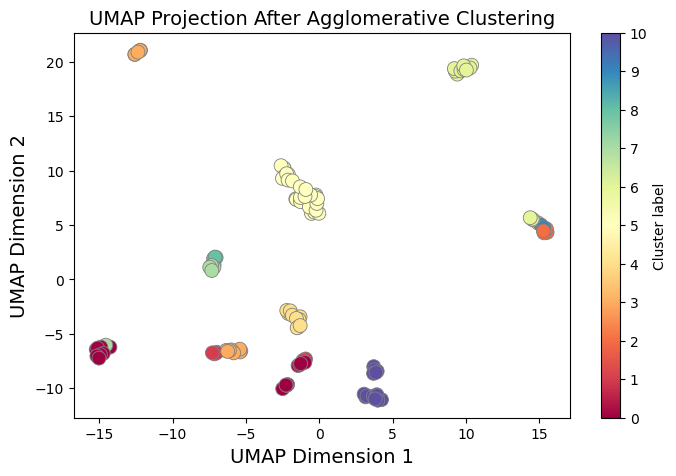

i = 19
DTW computation time: 4.990453243255615 seconds
Clustering Duration: 0:00:00.001209
Number of cluster labels: 116


/home/lee/miniconda3/envs/chrombert_test_v2/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


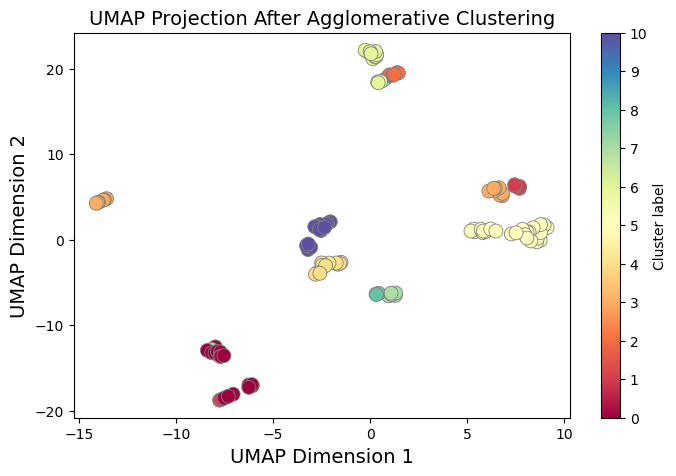

i = 94
DTW computation time: 4.772660970687866 seconds
Clustering Duration: 0:00:00.001225
Number of cluster labels: 116


/home/lee/miniconda3/envs/chrombert_test_v2/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


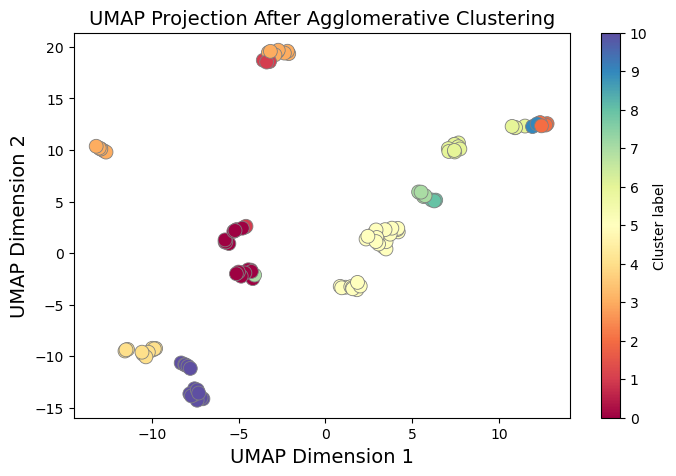

In [31]:
for i in [15,19,94]:
    print("i =", i)
    motif_init2umap(categorical=True, random_state=i)

In [61]:
def motif_init2pred_with_dendrogram(input_path="./init_concat.csv", categorical=False, fillna_method="ffill", n_clusters=None, linkage_method="average", threshold=35):
    """
    Read init.csv file and directly predict the class using DTW and Agglomerative Clustering.
    This version includes forward-reverse comparison. A dendrogram is provided to help the user 
    determine the optimal number of clusters.

    To run without specifying n_clusters, set n_clusters to None and adjust the threshold (e.g., 10 to 100).
    To run with a specified number of clusters, set n_clusters to the desired number.
    """

    def dataframe_reverse_and_push_nan(df):
        # Reverse rows of each column except 'position'
        df_rev = df.loc[:, df.columns != 'position'].apply(lambda col: col[::-1].values, axis=0)
        # Add the 'position' column back without changing its order
        df_rev.insert(0, 'position', df['position'])
        # Reset row index to ensure continuous row index
        df_rev = df_rev.reset_index(drop=True)

        # Push NaN values to the end of each column except 'position'
        for col in df_rev.columns:
            if col != 'position':
                non_nan = df_rev[col].dropna()
                nan_count = df_rev[col].isna().sum()
                df_rev[col] = pd.concat([non_nan, pd.Series([pd.NA] * nan_count)], ignore_index=True)
        
        return df_rev

    df_sequences = motif_init2df(input_path=input_path)
    # print(f"Initial number of entries: {len(df_sequences)}")  # Debug print

    X_train = df_sequences.loc[:, df_sequences.columns != 'position']
    if fillna_method == 0:
        X_train_filled = X_train.fillna(0)
    elif fillna_method == "ffill":
        X_train_filled = X_train.fillna(method=fillna_method)
    # Add more conditions for other fillna methods if needed
    n_columns = X_train_filled.shape[1]
    # print(f"Number of entries after filling NaNs: {n_columns}")  # Debug print

    dtw_distance_matrix = np.zeros((n_columns, n_columns))

    df_sequences_rev = dataframe_reverse_and_push_nan(df_sequences)  # Reverse
    X_train_rev = df_sequences_rev.loc[:, df_sequences_rev.columns != 'position']
    if fillna_method == 0:
        X_train_filled_rev = X_train_rev.fillna(0)
    elif fillna_method == "ffill":
        X_train_filled_rev = X_train_rev.fillna(method=fillna_method)
    # Add more conditions for other fillna methods if needed

    def categorical_distance(a, b):
        return 0 if a == b else 1

    def dtw_categorical(seq1, seq2):
        n, m = len(seq1), len(seq2)
        dtw = np.full((n+1, m+1), np.inf)
        dtw[0, 0] = 0
        for i in range(1, n+1):
            for j in range(1, m+1):
                cost = categorical_distance(seq1[i-1], seq2[j-1])
                dtw[i, j] = cost + min(dtw[i-1, j],    # insertion
                                    dtw[i, j-1],    # deletion
                                    dtw[i-1, j-1])  # match
        return dtw[n, m]

    import time
    start_dtw = time.time()
    for i in range(n_columns):
        for j in range(i, n_columns):  # No need to compute the distance twice for (i, j) and (j, i)
            if categorical:
                distance_ff=dtw_categorical(X_train_filled.iloc[:, i].values, X_train_filled.iloc[:, j].values)  # Forward-forward
                distance_fr=dtw_categorical(X_train_filled.iloc[:, i].values, X_train_filled_rev.iloc[:, j].values)  # Forward-reverse
            else:
                distance_ff = dtw(X_train_filled.iloc[:, i].values, X_train_filled.iloc[:, j].values)  # Forward-forward
                distance_fr = dtw(X_train_filled.iloc[:, i].values, X_train_filled_rev.iloc[:, j].values)  # Forward-reverse

                # Select the minimum distance and assign symmetrically
            min_distance = min(distance_ff, distance_fr)
            dtw_distance_matrix[i, j] = min_distance
            dtw_distance_matrix[j, i] = min_distance
            
            
    end_dtw = time.time()
    print(f"DTW computation time: {end_dtw - start_dtw} seconds")

    # Measure time for clustering
    start_clustering = datetime.now()
    
    # Added part for dendrogram
    # Create the linkage matrix
    Z = linkage(dtw_distance_matrix, method=linkage_method)
    
    # ############
    # max_distance = max(Z[:, 2])
    # threshold_test = max_distance / 2
    # print("threshold_test",threshold_test)
    # ############


    # Plot the dendrogram
    plt.figure(figsize=(10, 7))
    # dendrogram(Z)
    dendrogram(Z, color_threshold=threshold)
    plt.title('Dendrogram')
    plt.xlabel('Sample index')
    plt.ylabel('Distance')
    plt.show()
    # End of added part for dendrogram

    if n_clusters is None:
        # Determine clusters using fcluster with a distance threshold
        y_pred = fcluster(Z, threshold, criterion='distance')
        estimated_clusters = len(np.unique(y_pred))
        print(f"Estimated number of clusters: {estimated_clusters}")
    else:
        # Use Agglomerative Clustering with the precomputed DTW distance matrix
        clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage=linkage_method)
        y_pred = clustering.fit_predict(dtw_distance_matrix)
        estimated_clusters = n_clusters
    
    end_clustering = datetime.now()
    print('Clustering Duration: {}'.format(end_clustering - start_clustering))
    
    print(f"Number of cluster estimated by dendrogram with designated threshold {threshold}: [{estimated_clusters}] clusters")


    # print("threshold_test",threshold_test)
    
    return y_pred



In [2]:
def motif_init2class_vis(input_path="./init_concat.csv", categorical=False, fillna_method="ffill", n_clusters=11):
    """
    Read init.csv file and visualize the predicted class using DTW and Agglomerative Clustering.
    This version includes forward-reverse comparison.
    This version considers the difference in state as categorical if categorical=True.

    Parameters:
    - input_path (str): Path to the input CSV file.
    - categorical (bool): Whether to treat the data as categorical.
    - fillna_method (str or int): Method to fill missing values. Use "ffill" for forward fill or 0 to fill with zeros.
    - n_clusters (int): Number of clusters for Agglomerative Clustering.

    
    Returns:
    - Visualization of each motif clustered in the same line color and line style.
    - X axis indicates the position of the chromatin state in a sequence
    - Y axis represents the type of chromatin state
    """
    df_sequences = motif_init2df(input_path=input_path)
    _, y_pred = motif_init2pred(input_path=input_path, categorical=categorical,fillna_method=fillna_method, n_clusters=n_clusters)

    from itertools import cycle
    from matplotlib import cm

    # Set the figure size and legend location
    rcParams["figure.figsize"] = (12, 6)
    rcParams["legend.loc"] = 'upper right'

    # Assuming df_sequences is your DataFrame and y_pred is your array of predicted cluster labels
    item_list = df_sequences.columns.tolist()[1:]

    # Define a list of linestyles
    linestyles = ['-', '--', '-.', ':']

    # Create a cycle object from the linestyles list
    linestyle_cycle = cycle(linestyles)

    # Assign a linestyle to each cluster, cycling through the available styles
    cluster_linestyles = {i: next(linestyle_cycle) for i in range(n_clusters)}
    
    # Load a colormap
    cmap = cm.get_cmap('tab20', n_clusters) 
    
    # Map y_pred to colors
    cluster_colors = {i: cmap(i / n_clusters) for i in range(n_clusters)}

    # Create a figure and a subplot
    fig, ax = plt.subplots()
    
    # Use these colors in your plot
    for index, item in enumerate(item_list):
        linestyle = cluster_linestyles[y_pred[index]]
        color = cluster_colors[y_pred[index]]  # Get color from cluster_colors
        ax.plot(df_sequences["position"], df_sequences[item].astype('float'), 
                label=f"{item}_cluster{y_pred[index]}", 
            linestyle=linestyle, color=color)
    

    ax.set_xticks(df_sequences["position"])
    ax.set_xticklabels(df_sequences['position'].str.extract('(\d+)')[0].astype(int),fontsize=14)
    y_ticks = np.arange(1, len(state_col_dict_num.keys()) + 1)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(list(state_col_dict_num.keys()), fontsize=14)  
    # fig.savefig("./test_vis1.png",bbox_inches='tight', dpi=300)
    # Show the plot
    plt.show()

DTW computation time: 4.702824115753174 seconds
Clustering Duration: 0:00:00.002485
Number of cluster labels: 116


/tmp/ipykernel_7810/2469377096.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', n_clusters)


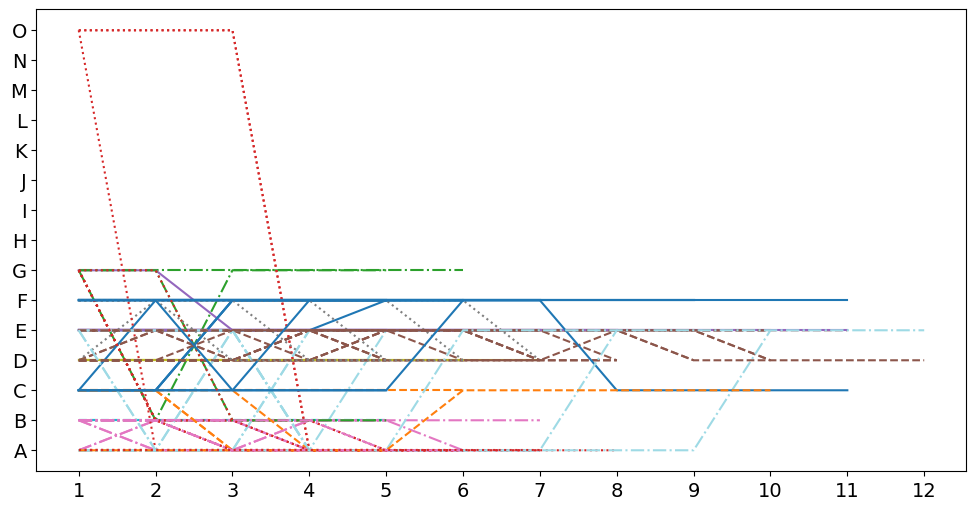

In [3]:
motif_init2class_vis(categorical=True)

In [2]:
def crm_df_maker(crm_path="../database/remap2022/remap2022_crm_macs2_hg19_v1_0.bed", limit_len=3):
    # Load the data
    crm_raw = pd.read_csv(crm_path, sep='\t', header=None, names=["chromosome", "start", "end", "name", "score", "strand", "thickStart", "thickEnd", "itemRgb"])
    
    # Convert start and end locations to units of 200 bps and calculate length
    crm_raw['start'] = (crm_raw['start'] / 200).round().astype(int)
    crm_raw['end'] = (crm_raw['end'] / 200).round().astype(int)
    crm_raw['length'] = crm_raw['end'] - crm_raw['start'] + 1

    # Filter by chromosome and length
    crm_df = crm_raw[crm_raw["chromosome"].str.contains('^chr[0-9XY]+$') & (crm_raw['length'] >= limit_len)].copy()
    
    # Define chromosome order
    chromosome_order = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10',
                        'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19',
                        'chr20', 'chr21', 'chr22', 'chrX', 'chrY']

    # Convert 'chromosome' to a categorical type with the defined order
    crm_df['chromosome'] = pd.Categorical(crm_df['chromosome'], categories=chromosome_order, ordered=True)

    # Sort by 'chromosome' and 'start'
    crm_df = crm_df.sort_values(['chromosome', 'start'])
    crm_df_fin = crm_df[["chromosome","start" ,"end","length","name"]]

    # Print summary
    print("{} out of total {} CRM entries are longer than 200x{}, which is approx. {} %".format(len(crm_df), len(crm_raw), limit_len, round(len(crm_df)/len(crm_raw), 3)))
    
    return crm_df_fin

In [3]:
### cut the css according to the CRM position
def extCRMfromCell(css_sample_path="../database/roadmap/css_unit_pickled/E003_unitcss_woChrM.pkl",crm_path="../database/remap2022/remap2022_crm_macs2_hg19_v1_0.bed",limit_len=4):
    #### load unit-css per chromosome of one cell
    with open(css_sample_path, "rb") as s:
        unit_css=pickle.load(s)
    #### make CRM as a dataframe
    crm_df_fin=crm_df_maker(crm_path=crm_path,limit_len=limit_len)
    
    cut_lst_all=[]
    for chr in range(len(unit_css)):
        unit_css_chr=unit_css[chr]
        chromosome_order = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10',
                            'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19',
                            'chr20', 'chr21', 'chr22', 'chrX', 'chrY']
        crm_df_chr=crm_df_fin[crm_df_fin["chromosome"]==chromosome_order[chr]]

        cut_lst=[]
        for i in range(len(crm_df_chr)):
            start_loc=crm_df_chr["start"].iloc[i]
            end_loc=crm_df_chr["end"].iloc[i]
            # length=crm_df_fin["length"].iloc[i]     
            cut=unit_css_chr[start_loc:end_loc+1]
            cut_lst.append(cut)
        cut_lst_all.append(cut_lst)
    return cut_lst_all

In [4]:
def extCRMfromCell_all(input_path="../database/roadmap/css_unit_pickled/", crm_path="../database/remap2022/remap2022_crm_macs2_hg19_v1_0.bed", output_path="../database/remap2022/crm/", limit_len=6):
    files=os.listdir(input_path)
    css_paths=[os.path.join(input_path, file) for file in files if "E" in file]  # list of paths for css of cells
    for css_sample_path in css_paths:
        cut_lst_all=extCRMfromCell(css_sample_path=css_sample_path,crm_path=crm_path,limit_len=limit_len)
         
        file_name=re.search(r'E\d{3}_unitcss_', css_sample_path).group(0)
        output_file=os.path.join(output_path,file_name+"limit_len"+str(limit_len)+".pkl")
        with open(output_file,"wb") as f:
            pickle.dump(cut_lst_all,f)
    return print("All files are saved at {}, with limit_len={}".format(output_path, limit_len))


In [7]:
# test_path="../database/remap2022/crm/lim10/E001_unitcss_limit_len10.pkl"
# with open(test_path,"rb") as f:
#     test=pickle.load(f)

In [27]:
def saveCRMforPREall_mod(input_path="../database/remap2022/crm/",output_path="../database/pretrain/crm/",limit_len=10, k=4): 
    files=os.listdir(os.path.join(input_path,"lim"+str(limit_len)))
    css_all=[]
    for file in files:
        file_name=os.path.basename(file)
        if file_name[0] == 'E' and file_name[1:4].isdigit():
            file_id = file_name[:4]
        else:
            pass
        # ##########################
        # if str(file_id)=="E003":
        #     break  # for test
        # ##########################
        with open(os.path.join(input_path,"lim"+str(limit_len),file), "rb") as f:
            css_lst=pickle.load(f)
        css=flatLst(css_lst)
        css_kmer=[]
        for css_chr in css:
            css_chr_kmer=seq2kmer(css_chr,k)
            target_to_remove="O"*k   # get rid of the word with continuous 15th state "o"
            css_chr_kmer_trim = css_chr_kmer.replace(target_to_remove, "")
            # clean up extra spaces
            css_chr_kmer_trim = ' '.join(css_chr_kmer_trim.split())
            css_kmer.append(css_chr_kmer_trim)
        # _, kmerized_unit_css=css_CUT_Kmer(css, cut_thres=510, k=k)
        css_all.append(css_kmer)
    css_all_flt=flatLst(css_all)
    os.makedirs(os.path.join(output_path, "lim" + str(limit_len)), exist_ok=True)
    output_name="crm_lim"+str(limit_len)+"_allcell_wo_cnt_o"+str(k)+"merized.txt"
    with open(os.path.join(output_path,"lim"+str(limit_len),output_name), "w") as g:
            g.write("\n".join(css_all_flt))
    return print("File is saved at {}".format(output_path))

In [28]:
saveCRMforPREall_mod(input_path="../database/remap2022/crm/",output_path="../database/pretrain/crm/wo_continuous_o/",limit_len=10, k=4)

File is saved at ../database/pretrain/crm/wo_continuous_o/


In [8]:
with open("../database/pretrain/genome/wo_continuous_o/4mer/pretrain_genome_all.txt","r") as file:
    for i in range(10):
        line=file.readline().strip()
        if line:
            print(line)

O
O
O
I
O
O
I
I


In [69]:
## create pretrain dataset for all 127 cells
# check what's inside 
with open("../database/roadmap/css_unit_pickled/E001_unitcss_woChrM.pkl","rb") as f:
    test_css=pickle.load(f)

In [70]:
css=test_css

In [74]:
# Preprocessing for removing continuous O state for pretrain dataset
 
def save_css_by_cell_wo_continuous_15state(path_to_css_unit_pickled, output_path,k=4):
    # read files from css_unit_pickled
    files=os.listdir(path_to_css_unit_pickled)
    file_path_lst=[os.path.join(path_to_css_unit_pickled,file) for file in files]
    for file_path in file_path_lst:
        file_name=os.path.basename(file_path)
        if file_name[0] == 'E' and file_name[1:4].isdigit():
            file_id = file_name[:4]
        else:
            pass
        # ##########################
        # if str(file_id)=="E003":
        #     break  # for test
        # ##########################
        with open(file_path,"rb") as f:
            css=pickle.load(f)
        css_kmer=[]
        for css_chr in css:
            css_chr_kmer=seq2kmer(css_chr,k)
            target_to_remove="O"*k   # get rid of the word with continuous 15th state "o"
            css_chr_kmer_trim = css_chr_kmer.replace(target_to_remove, "")
            # clean up extra spaces
            css_chr_kmer_trim = ' '.join(css_chr_kmer_trim.split())
            css_kmer.append(css_chr_kmer_trim)
        output_file_name=os.path.join(output_path,file_id+"_unitcss_wo_all"+str(k)+"O_state.pkl")    
        with open(output_file_name, "wb") as g:
            pickle.dump(css_kmer, g)  # note that it is chromosome-wise list (each element corresponds to each chromosome)

        print("trimmed css by cell saved: ",file_id)
    return 


In [75]:
path_to_css_unit_pickled="/home/lee/Work/chromatin_state/database/roadmap/css_unit_pickled"
output_path="../database/roadmap/css_unit_4mer_cut4o_pickled"
save_css_by_cell_wo_continuous_15state(path_to_css_unit_pickled, output_path,k=4)

trimmed css by cell saved:  E001
trimmed css by cell saved:  E002
trimmed css by cell saved:  E003
trimmed css by cell saved:  E004
trimmed css by cell saved:  E005
trimmed css by cell saved:  E006
trimmed css by cell saved:  E007
trimmed css by cell saved:  E008
trimmed css by cell saved:  E009
trimmed css by cell saved:  E010
trimmed css by cell saved:  E011
trimmed css by cell saved:  E012
trimmed css by cell saved:  E013
trimmed css by cell saved:  E014
trimmed css by cell saved:  E015
trimmed css by cell saved:  E016
trimmed css by cell saved:  E017
trimmed css by cell saved:  E018
trimmed css by cell saved:  E019
trimmed css by cell saved:  E020
trimmed css by cell saved:  E021
trimmed css by cell saved:  E022
trimmed css by cell saved:  E023
trimmed css by cell saved:  E024
trimmed css by cell saved:  E025
trimmed css by cell saved:  E026
trimmed css by cell saved:  E027
trimmed css by cell saved:  E028
trimmed css by cell saved:  E029
trimmed css by cell saved:  E030
trimmed cs

In [4]:
with open("../database/roadmap/css_unit_4mer_cut4o_pickled/E001_unitcss_wo_all4O_state.pkl", "rb") as f:
    test_data=pickle.load(f)

In [6]:
type(test_data)

list

In [7]:
len(test_data)

24

In [5]:
test_data[0][:100]

'OOOI OOII OIII IIII IIIO IIOO IOOO OOOA OOAA OAAO AAOO AOOO OOOI OOIO OIOO IOOO OOOA OOAA OAAA AAAA '

In [21]:
def kmerCSS_to_pretrain_data(path_to_kmer_css_unit_pickled,output_path):
    files=os.listdir(path_to_kmer_css_unit_pickled)
    file_path_lst=[os.path.join(path_to_kmer_css_unit_pickled,file) for file in files]

    css_all=[]
    for file_path in file_path_lst:
        file_name=os.path.basename(file_path)
        if file_name[0] == 'E' and file_name[1:4].isdigit():
            file_id = file_name[:4]
        else:
            pass
        # ##########################
        # if str(file_id)=="E003":
        #     break  # for test
        # # ##########################
        with open(file_path,"rb") as f:
            css=pickle.load(f)

        css_per_cell='\n'.join(css)   # join the chromosome by new line

        css_all.append(css_per_cell)   

    css_all_cell='\n'.join(css_all)  # join the cell by new line

    output_name=os.path.join(output_path,"pretrain_genome_all.txt") 
    with open(output_name, "w") as g:
        g.write(css_all_cell)

    return 

In [22]:
path_to_kmer_css_unit_pickled="../database/roadmap/css_unit_4mer_cut4o_pickled"
output_path="../database/pretrain/genome/wo_continuous_o/4mer"
kmerCSS_to_pretrain_data(path_to_kmer_css_unit_pickled,output_path)

type: css_all <class 'list'>
len: css_all 1
type: css_all <class 'list'>
len: css_all 2
type: css_all <class 'list'>
len: css_all 3
type: css_all <class 'list'>
len: css_all 4
type: css_all <class 'list'>
len: css_all 5
type: css_all <class 'list'>
len: css_all 6
type: css_all <class 'list'>
len: css_all 7
type: css_all <class 'list'>
len: css_all 8
type: css_all <class 'list'>
len: css_all 9
type: css_all <class 'list'>
len: css_all 10
type: css_all <class 'list'>
len: css_all 11
type: css_all <class 'list'>
len: css_all 12
type: css_all <class 'list'>
len: css_all 13
type: css_all <class 'list'>
len: css_all 14
type: css_all <class 'list'>
len: css_all 15
type: css_all <class 'list'>
len: css_all 16
type: css_all <class 'list'>
len: css_all 17
type: css_all <class 'list'>
len: css_all 18
type: css_all <class 'list'>
len: css_all 19
type: css_all <class 'list'>
len: css_all 20
type: css_all <class 'list'>
len: css_all 21
type: css_all <class 'list'>
len: css_all 22
type: css_all <clas

In [2]:
df_sequences=motif_init2df(input_path="./init_concat.csv")

In [60]:
def motif_init2class_vis(input_path="./init_concat.csv", n_clusters=11):
    df_sequences = motif_init2df(input_path=input_path)
    y_pred = motif_init2pred(input_path=input_path, n_clusters=n_clusters)

    from itertools import cycle
    from matplotlib import cm

    # Set the figure size and legend location
    rcParams["figure.figsize"] = (12, 6)
    rcParams["legend.loc"] = 'upper right'

    # Assuming df_sequences is your DataFrame and y_pred is your array of predicted cluster labels
    item_list = df_sequences.columns.tolist()[1:]

    # Define a list of linestyles
    linestyles = ['-', '--', '-.', ':']

    # Create a cycle object from the linestyles list
    linestyle_cycle = cycle(linestyles)

    # Assign a linestyle to each cluster, cycling through the available styles
    cluster_linestyles = {i: next(linestyle_cycle) for i in range(n_clusters)}
    
    # Load a colormap
    cmap = cm.get_cmap('tab20', n_clusters) 
    
    # Map y_pred to colors
    cluster_colors = {i: cmap(i / n_clusters) for i in range(n_clusters)}

    # Create a figure and a subplot
    fig, ax = plt.subplots()
    
    # Use these colors in your plot
    for index, item in enumerate(item_list):
        linestyle = cluster_linestyles[y_pred[index]]
        color = cluster_colors[y_pred[index]]  # Get color from cluster_colors
        ax.plot(df_sequences["position"], df_sequences[item].astype('float'), 
                label=f"{item}_cluster{y_pred[index]}", 
            linestyle=linestyle, color=color)
    

    ax.set_xticks(df_sequences["position"])
    ax.set_xticklabels(df_sequences['position'].str.extract('(\d+)')[0].astype(int),fontsize=14)
    y_ticks = np.arange(1, len(state_col_dict_num.keys()) + 1)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(list(state_col_dict_num.keys()), fontsize=14)  
    fig.savefig("./test_vis1.png",bbox_inches='tight', dpi=300)
    # Show the plot
    plt.show()

Duration: 0:00:06.575929


/var/folders/wq/xzmf_6p54qjf9pk01wx0yfsm0000gn/T/ipykernel_10205/3546992777.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', n_clusters)


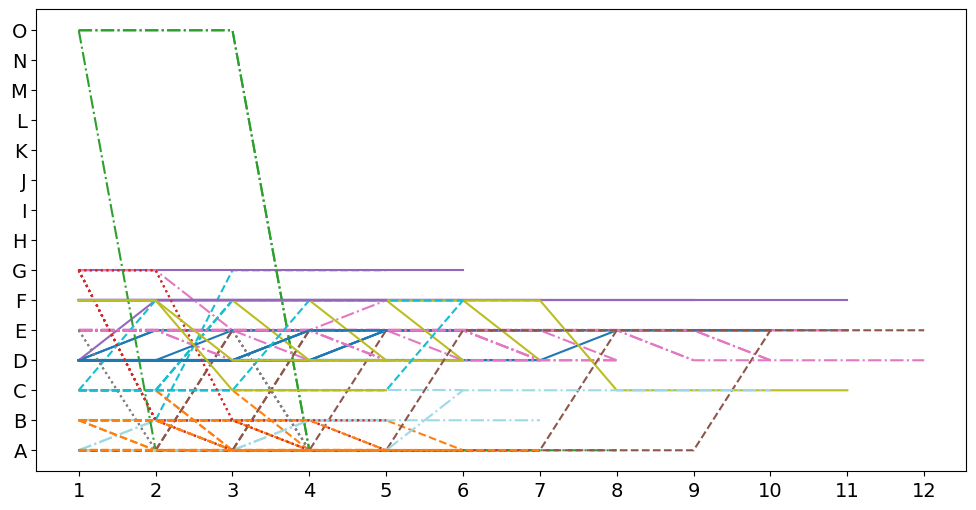

In [61]:
motif_init2class_vis(input_path="./init_concat.csv", n_clusters=11)

In [3]:
df_sequences=motif_init2df(input_path="./init_concat.csv")

In [4]:
df_sequences

,position,0,1,2,3,4,5,6,7,8,...,106,107,108,109,110,111,112,113,114,115
0,Pos 1,5,4,5,2,5,1,4,1,5,...,7,3,7,2,1,6,6,1,2,1
1,Pos 2,5,4,5,2,5,1,5,2,5,...,2,3,7,2,1,6,6,1,2,1
2,Pos 3,5,4,5,7,5,1,5,2,5,...,1,3,2,1,1,4,3,1,1,1
3,Pos 4,5,5,5,7,5,1,5,2,5,...,1,3,1,1,1,4,3,1,1,1
4,Pos 5,5,5,5,7,5,1,5,2,5,...,1,3,1,1,1,4,3,1,1,1
5,Pos 6,5,5,<NA>,<NA>,5,<NA>,5,<NA>,5,...,1,6,1,<NA>,5,<NA>,<NA>,3,1,1
6,Pos 7,<NA>,<NA>,<NA>,<NA>,5,<NA>,<NA>,<NA>,5,...,<NA>,<NA>,<NA>,<NA>,5,<NA>,<NA>,3,<NA>,1
7,Pos 8,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,5,...,<NA>,<NA>,<NA>,<NA>,5,<NA>,<NA>,3,<NA>,<NA>
8,Pos 9,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,5,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>
9,Pos 10,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>


In [5]:
y_pred=motif_init2pred(input_path="./init_concat.csv", n_clusters=11)

Duration: 0:00:07.088188


In [6]:
clustered_sequences=motif_init2class_df(input_path="./init_concat.csv", n_clusters=11)

Duration: 0:00:07.012915


In [7]:
clustered_sequences.head()

,Cluster,LetterSequence
0,0,"[KDDDDDDD, DDDDDDDEEE, DDDEE, DDDDD, DDDDEEEEE..."
1,1,"[CCCAA, BBBBA, AAAAA, BBAAAA, BBAAA, CCAAA, BA..."
2,2,"[OAAAA, OOOAAA, OOOAAAAA]"
3,3,"[GBBBB, GGBBB, GBBAA, GGBAAA, GBAAAAA, GBBBAA,..."
4,4,"[FFFFFFFFF, FFFFF, FFFFFFF, DFFFF, FFFFFFFFFFF..."


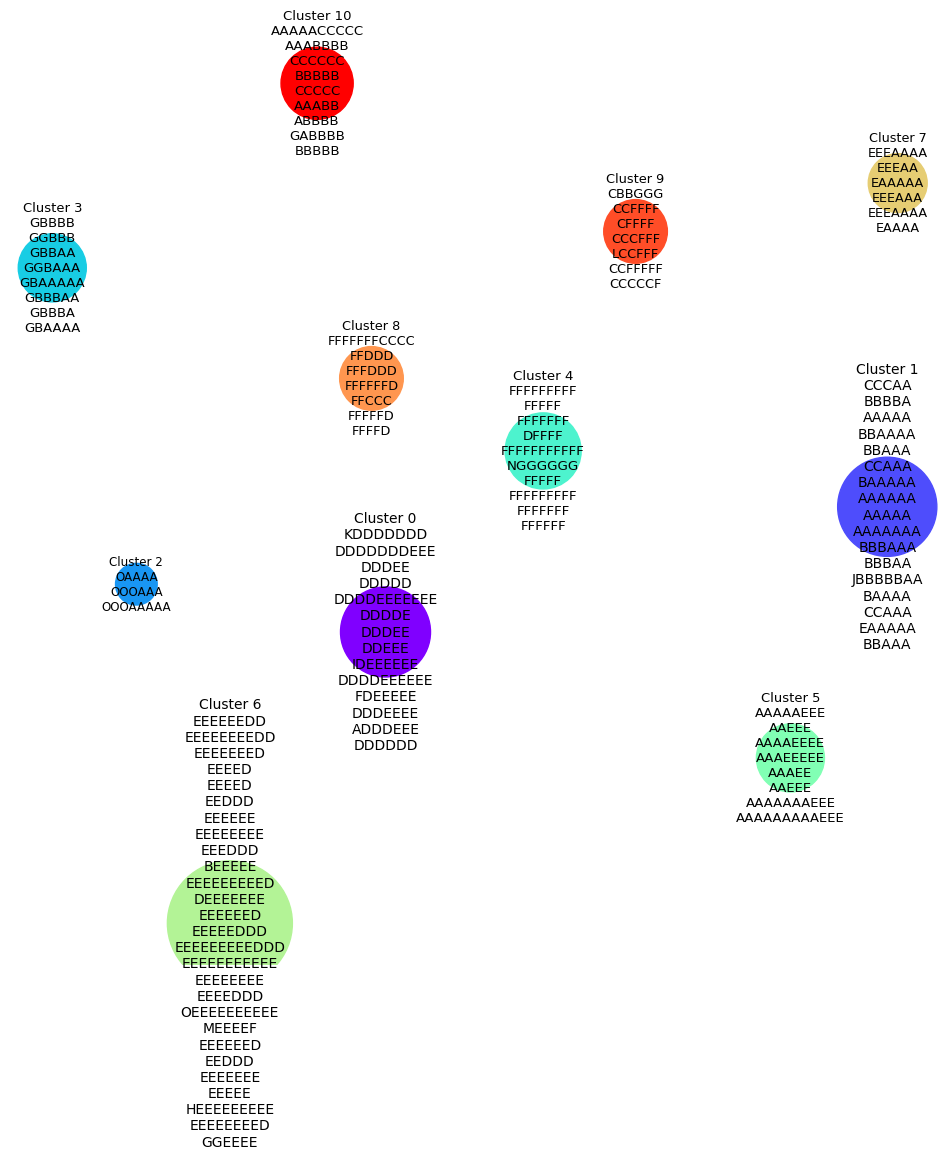

In [24]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

df=clustered_sequences

# Create a graph
G = nx.Graph()
for index, row in df.iterrows():
    G.add_node(row['Cluster'], elements=row['LetterSequence'])

# Increase the base size for each node to allow larger circles
base_node_size = 300
node_sizes = [len(elements) * base_node_size for elements in df['LetterSequence']]

# Generate a color palette with a unique color for each node
colors = plt.cm.rainbow(np.linspace(0, 1, len(df)))

# Adjust the figure size if necessary
plt.figure(figsize=(12,12))  # A larger figure to accommodate bigger nodes

# Draw the graph with a spring layout
# Decrease k to allow a slight overlap of nodes
pos = nx.spring_layout(G, k=0.03, iterations=10)

# Draw nodes with the calculated sizes and unique colors
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=colors)

# Create a function to scale text size to node size
def scale_text_size(node_size, max_text_size=10):
    base_size = 6  # Minimum text size
    return min(base_size + (node_size ** 0.3) / 3, max_text_size)

# Draw labels without bounding box and with scaled font sizes
for node, (node_pos, elements) in enumerate(zip(pos.values(), df['LetterSequence'])):
    x, y = node_pos
    plt.text(x, y, f"Cluster {df['Cluster'][node]}\n" + '\n'.join(elements),
             fontsize=scale_text_size(node_sizes[node]),
             ha='center', va='center')

# Remove the axis
plt.axis('off')

# Show the plot
plt.show()


In [7]:
state_col_255_dict

{'A': (255, 0, 0),
 'B': (255, 69, 0),
 'C': (50, 205, 50),
 'D': (0, 128, 0),
 'E': (0, 100, 0),
 'F': (194, 225, 5),
 'G': (255, 255, 0),
 'H': (102, 205, 170),
 'I': (138, 145, 208),
 'J': (205, 92, 92),
 'K': (233, 150, 122),
 'L': (189, 183, 107),
 'M': (128, 128, 128),
 'N': (192, 192, 192),
 'O': (240, 240, 240)}

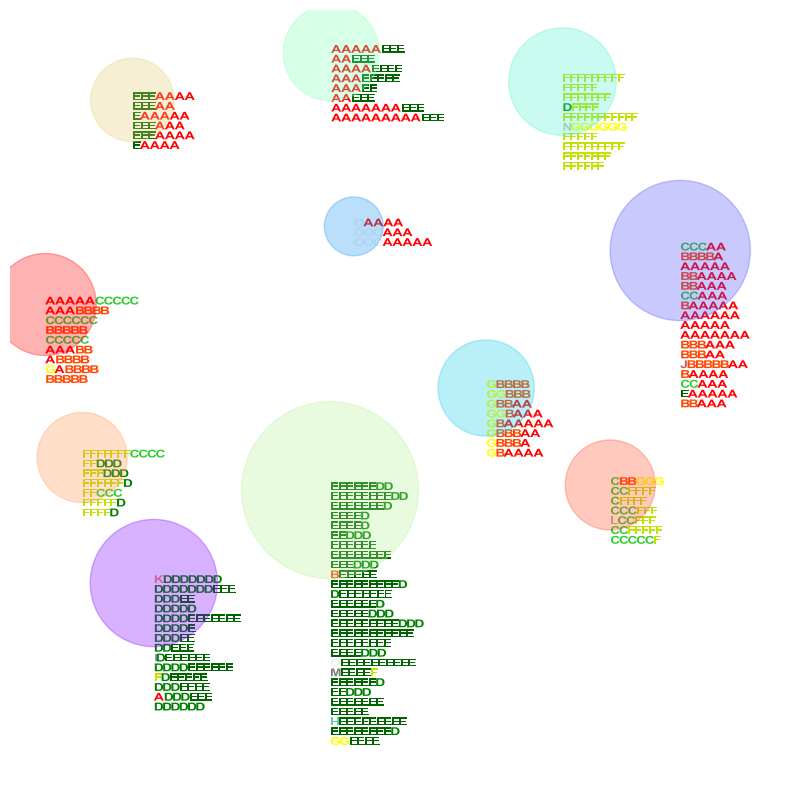

In [9]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.textpath import TextPath
from matplotlib.patches import PathPatch
import matplotlib.transforms as transforms
import networkx as nx
import numpy as np
import pandas as pd
import random


scale_factor = 0.004  # Adjust this to change the font size

def create_text_patch(x, y, text, state_col_dict_num, ax, scale_factor):
    # Determine the starting x position for the first letter
    x_offset = x
    for letter in text:
        color = state_col_dict_num.get(letter, (0, 0, 0))
        fp = FontProperties(family="Arial", weight="bold")
        tp = TextPath((0, 0), letter, prop=fp)
        tp_transformed = transforms.Affine2D().scale(scale_factor).translate(x_offset, y) + ax.transData
        letter_patch = PathPatch(tp, color=color, lw=0, transform=tp_transformed)
        ax.add_patch(letter_patch)
        # Get the width of the letter and add a small margin
        letter_width = tp.get_extents().width * scale_factor
        x_offset += letter_width  # Increment the x position by the width of the letter

df = clustered_sequences

fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# Create a graph
G = nx.Graph()
for index, row in df.iterrows():
    G.add_node(row['Cluster'], elements=row['LetterSequence'])

# Significantly increase the base size for each node
base_node_size = 600  # This increases the node size
node_sizes = [len(elements) * base_node_size for elements in df['LetterSequence']]

# Generate a color palette with a unique color for each node
colors = plt.cm.rainbow(np.linspace(0, 1, len(df)))

# Set the seed for the random number generator for reproducibility
np.random.seed(95)

# Draw the graph with a spring layout
# Adjust k to manage the distance between nodes, which can be smaller since nodes can overlap
pos = nx.spring_layout(G, k=0.05, iterations=10)


# Draw the nodes themselves
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=colors, alpha=0.3)

# Draw the text
for node, (node_pos, elements) in enumerate(zip(pos.values(), df['LetterSequence'])):
    x_start, y_start = node_pos
    for i, element in enumerate(elements):
        y_position = y_start - (i * scale_factor * 9)  # Adjust line spacing
        create_text_patch(x_start, y_position, element, state_col_dict_num, ax, scale_factor)
#         print("element",element)


plt.axis('off')
plt.show()

In [10]:
####### not this ######
def motif_init2cluster_vis_bu(input_path="./init_concat.csv", n_clusters=11, random_state=95, font_scale=0.004,font_v_scale=9, fig_w=10, fig_h=10, node_size=600, node_dist=0.05):
    clustered_sequences=motif_init2class_df(input_path=input_path, n_clusters=n_clusters)
    scale_factor = font_scale  # Adjust this to change the font size

    def create_text_patch(x, y, text, state_col_dict_num, ax, scale_factor):
        # Determine the starting x position for the first letter
        x_offset = x
        for letter in text:
            color = state_col_dict_num.get(letter, (0, 0, 0))
            fp = FontProperties(family="Arial", weight="bold")
            tp = TextPath((0, 0), letter, prop=fp)
            tp_transformed = transforms.Affine2D().scale(scale_factor).translate(x_offset, y) + ax.transData
            letter_patch = PathPatch(tp, color=color, lw=0, transform=tp_transformed)
            ax.add_patch(letter_patch)
            # Get the width of the letter and add a small margin
            letter_width = tp.get_extents().width * scale_factor
            x_offset += letter_width  # Increment the x position by the width of the letter

    df = clustered_sequences
    
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))  # Adjust figure size as needed

    # Create a graph
    G = nx.Graph()
    for index, row in df.iterrows():
        G.add_node(row['Cluster'], elements=row['LetterSequence'])

    # Significantly increase the base size for each node
    base_node_size = node_size  # This increases the node size
    node_sizes = [len(elements) * base_node_size for elements in df['LetterSequence']]

    # Generate a color palette with a unique color for each node
    colors = plt.cm.rainbow(np.linspace(0, 1, len(df)))

    np.random.seed(random_state)
    # Draw the graph with a spring layout
    # Adjust k to manage the distance between nodes, which can be smaller since nodes can overlap
    pos = nx.spring_layout(G, k=node_dist, iterations=10)

    # Draw the nodes themselves
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=colors, alpha=0.3)

    # Draw the text
    for node, (node_pos, elements) in enumerate(zip(pos.values(), df['LetterSequence'])):
        x_start, y_start = node_pos
        for i, element in enumerate(elements):
            y_position = y_start - (i * scale_factor * font_v_scale)  # Adjust line spacing
            create_text_patch(x_start, y_position, element, state_col_dict_num, ax, scale_factor)
            print("element:", element)

    plt.axis('off')
    plt.show()

Duration: 0:00:06.931838


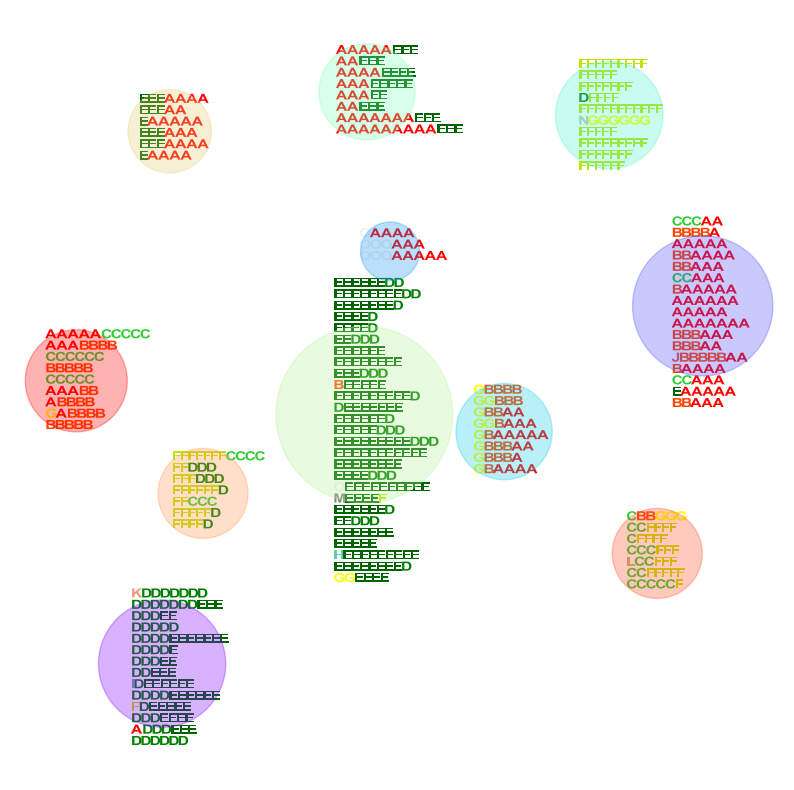

In [11]:
####### not this ######
motif_init2cluster_vis_bu(input_path="./init_concat.csv", n_clusters=11, random_state=95, font_scale=0.004,font_v_scale=9, fig_w=10, fig_h=10, node_size=600, node_dist=0.03)

In [23]:
def motif_init2cluster_vis_test(input_path="./init_concat.csv", n_clusters=11, random_state=95, font_scale=0.004,font_v_scale=9, fig_w=10, fig_h=10, node_size=600, node_dist=0.05):
    clustered_sequences=motif_init2class_df(input_path=input_path, n_clusters=n_clusters)
    scale_factor = font_scale  # Adjust this to change the font size

    def create_text_patch(x, y, text, state_col_dict_num, ax, scale_factor):
        # Determine the starting x position for the first letter
        x_offset = x
        for letter in text:
            color = state_col_dict_num.get(letter, (0, 0, 0))
            fp = FontProperties(family="Arial", weight="bold")
            tp = TextPath((0, 0), letter, prop=fp)
            tp_transformed = transforms.Affine2D().scale(scale_factor).translate(x_offset, y) + ax.transData
            letter_patch = PathPatch(tp, color=color, lw=0, transform=tp_transformed)
            ax.add_patch(letter_patch)
            # Get the width of the letter and add a small margin
            letter_width = tp.get_extents().width * scale_factor
            x_offset += letter_width  # Increment the x position by the width of the letter

    df = clustered_sequences

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))  # Adjust figure size as needed
    
    ##### color modification for temporary use #####
    # Create a temporary copy with a different name
    temp_state_col_dict_num = state_col_dict_num.copy()

    # Modify the colors in the temporary dictionary
    # Update 'G' to a more visible color, such as a deep orange
    temp_state_col_dict_num['G'] = (1.0, 0.647, 0.0)  # Normalized deep orange

    # Update 'O' to ensure it stands out more, such as a darker gray
    temp_state_col_dict_num['O'] = (0.502, 0.502, 0.502)  # Normalized darker gray

    ################################################

    # Create a graph
    G = nx.Graph()
    for index, row in df.iterrows():
        G.add_node(row['Cluster'], elements=row['LetterSequence'])

    # Significantly increase the base size for each node
    base_node_size = node_size  # This increases the node size
    node_sizes = [len(elements) * base_node_size for elements in df['LetterSequence']]

    # Generate a color palette with a unique color for each node
    colors = plt.cm.rainbow(np.linspace(0, 1, len(df)))

    np.random.seed(random_state)
    # Draw the graph with a spring layout
    # Adjust k to manage the distance between nodes, which can be smaller since nodes can overlap
    pos = nx.spring_layout(G, k=node_dist, iterations=10)

    # Draw the nodes themselves
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=colors, alpha=0.3)

    # Draw the text
    for node, (node_pos, elements) in enumerate(zip(pos.values(), df['LetterSequence'])):      
        x_start, y_start = node_pos
        for i, element in enumerate(elements):
            x_position = x_start - 0.08
            y_position = y_start - (i * scale_factor * font_v_scale) + 0.015*len(elements)# Adjust line spacing
            create_text_patch(x_position, y_position, element, temp_state_col_dict_num, ax, scale_factor)
#             print("state_col_dict_num", state_col_dict_num)

#     plt.axis('off')
    plt.show()
    
    fig.savefig("./test_cluster_2.png",bbox_inches='tight', dpi=300)

Duration: 0:00:06.661485


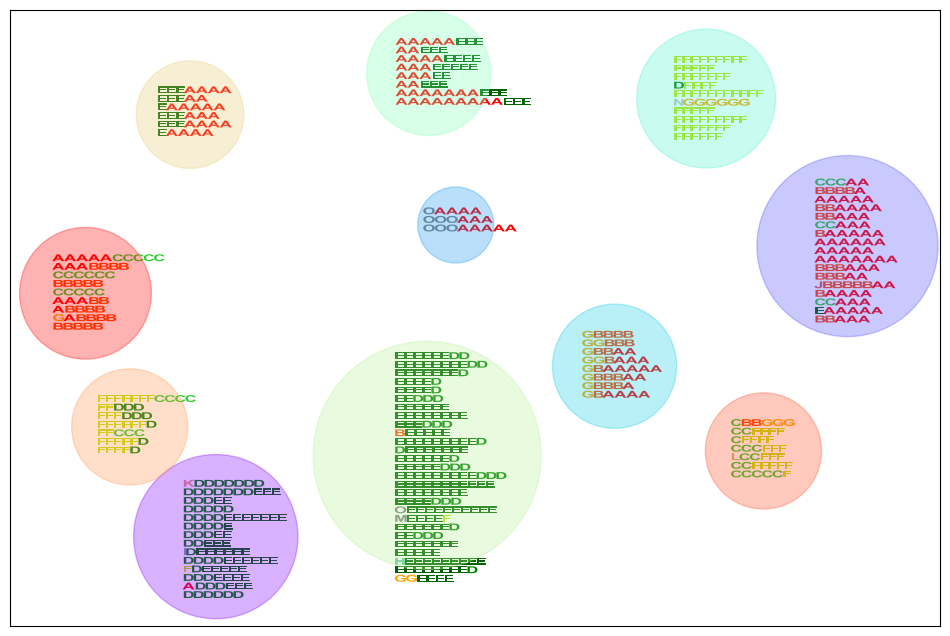

In [25]:
motif_init2cluster_vis_test(input_path="./init_concat.csv", n_clusters=11, random_state=95, font_scale=0.004,font_v_scale=9, fig_w=12, fig_h=8, node_size=1000, node_dist=0.05)

Duration: 0:00:06.917571


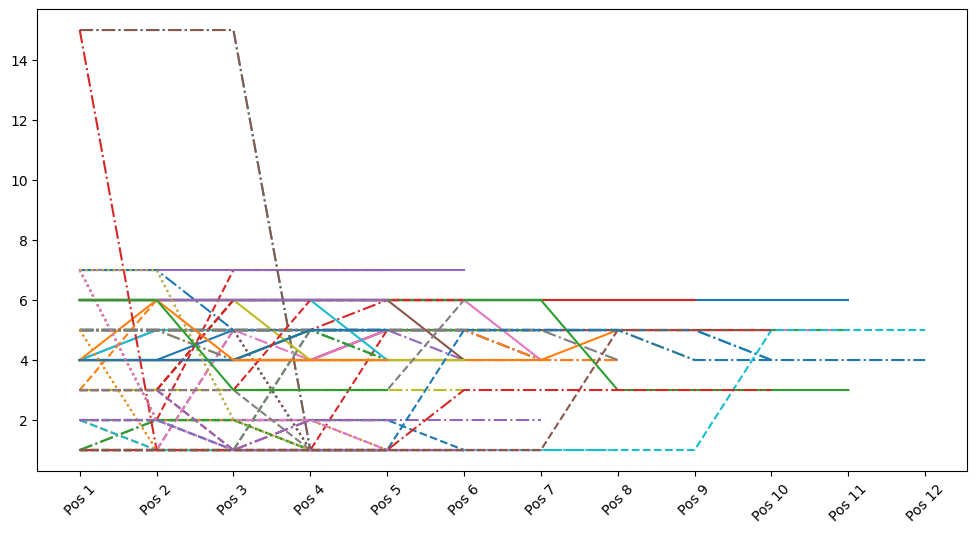

In [8]:
motif_init2class_vis(input_path="./init_concat.csv", n_clusters=11)

Duration: 0:00:06.955901


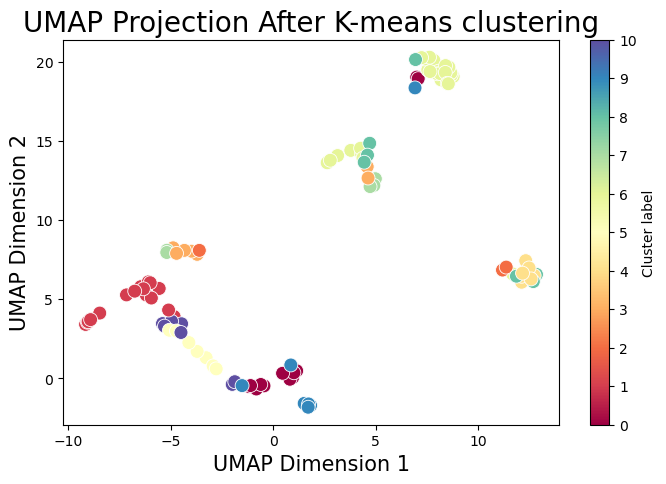

In [9]:
motif_init2umap(input_path="./init_concat.csv", n_clusters=11, n_neighbors=5, min_dist=0.3, random_state=111)

In [20]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import umap 

In [12]:
# Generating synthetic data (use your actual data here)
data, _ = make_blobs(n_samples=100, centers=3, n_features=50, random_state=42)

In [13]:
data

array([[  8.84157727,   5.35563104,   9.63071331, ...,   0.44810906,
         -9.33492374,  -6.81864082],
       [ -3.04452581,   8.92375285,   4.97185917, ...,   1.14348791,
          1.00963923,  -7.9048767 ],
       [-10.02710401,   2.49249698,  -4.65234362, ...,   0.78712828,
         -8.96164132,  -4.66475403],
       ...,
       [ 10.26084862,   6.3899473 ,   8.02669273, ...,  -0.90191484,
         -8.94273363,  -8.09712725],
       [  9.85489885,   4.13551866,   9.63815304, ...,   0.08318809,
         -8.99175334,  -9.24147763],
       [ -2.59893332,  10.45440334,   3.96348653, ...,   0.59896003,
          3.00946646,  -6.99209871]])

In [24]:
data.shape

(100, 50)

In [15]:
# Example text sequences
texts = [f"Seq{i+1:02d}" for i in range(100)]  # Replace with your actual text sequences
texts

['Seq01',
 'Seq02',
 'Seq03',
 'Seq04',
 'Seq05',
 'Seq06',
 'Seq07',
 'Seq08',
 'Seq09',
 'Seq10',
 'Seq11',
 'Seq12',
 'Seq13',
 'Seq14',
 'Seq15',
 'Seq16',
 'Seq17',
 'Seq18',
 'Seq19',
 'Seq20',
 'Seq21',
 'Seq22',
 'Seq23',
 'Seq24',
 'Seq25',
 'Seq26',
 'Seq27',
 'Seq28',
 'Seq29',
 'Seq30',
 'Seq31',
 'Seq32',
 'Seq33',
 'Seq34',
 'Seq35',
 'Seq36',
 'Seq37',
 'Seq38',
 'Seq39',
 'Seq40',
 'Seq41',
 'Seq42',
 'Seq43',
 'Seq44',
 'Seq45',
 'Seq46',
 'Seq47',
 'Seq48',
 'Seq49',
 'Seq50',
 'Seq51',
 'Seq52',
 'Seq53',
 'Seq54',
 'Seq55',
 'Seq56',
 'Seq57',
 'Seq58',
 'Seq59',
 'Seq60',
 'Seq61',
 'Seq62',
 'Seq63',
 'Seq64',
 'Seq65',
 'Seq66',
 'Seq67',
 'Seq68',
 'Seq69',
 'Seq70',
 'Seq71',
 'Seq72',
 'Seq73',
 'Seq74',
 'Seq75',
 'Seq76',
 'Seq77',
 'Seq78',
 'Seq79',
 'Seq80',
 'Seq81',
 'Seq82',
 'Seq83',
 'Seq84',
 'Seq85',
 'Seq86',
 'Seq87',
 'Seq88',
 'Seq89',
 'Seq90',
 'Seq91',
 'Seq92',
 'Seq93',
 'Seq94',
 'Seq95',
 'Seq96',
 'Seq97',
 'Seq98',
 'Seq99',
 'Seq100']

In [21]:
# Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data)

/Users/schona/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/Users/schona/anaconda3/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


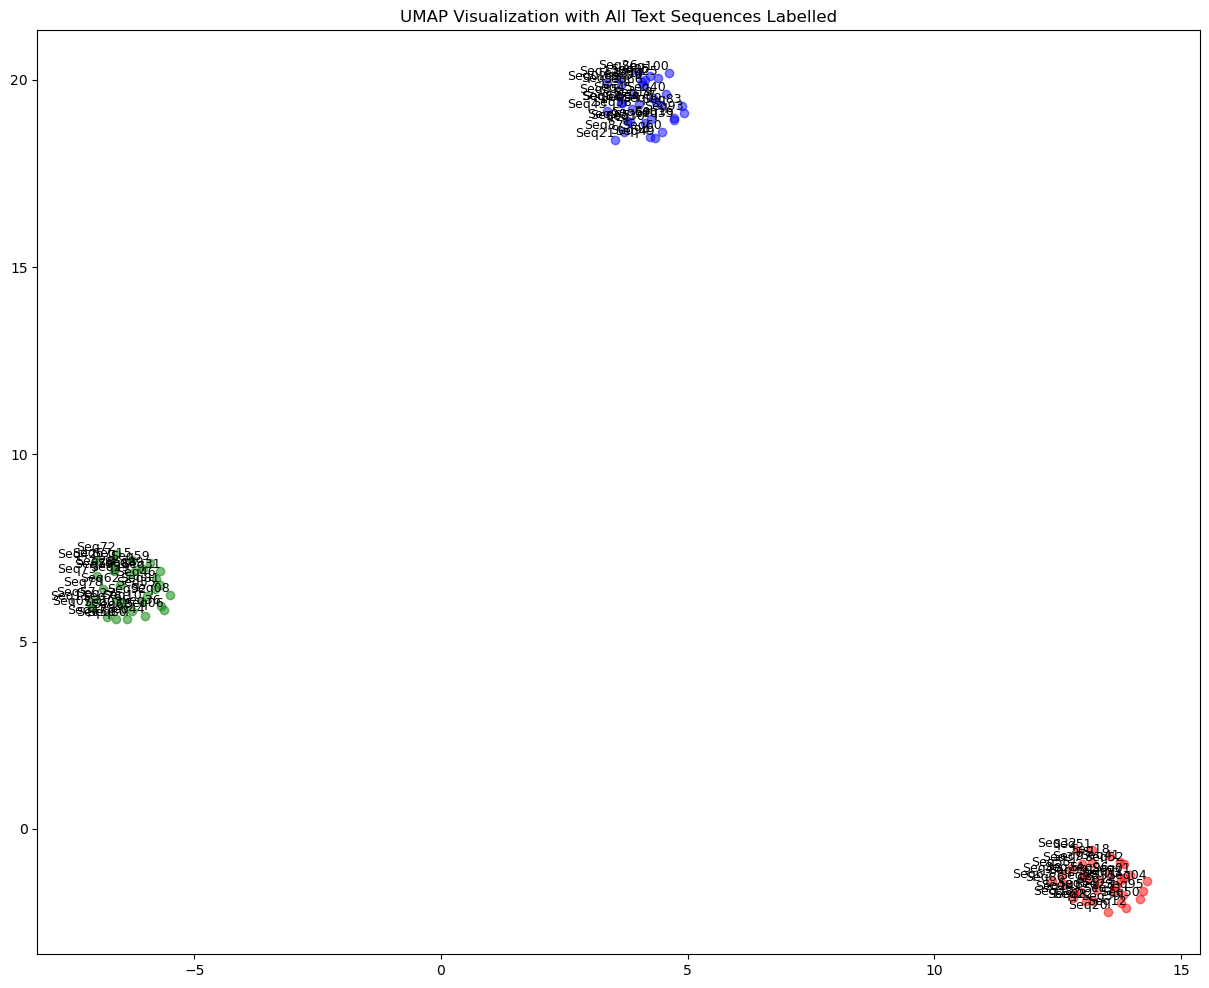

In [22]:
# Dimensionality Reduction
umap = UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
data_transformed = umap.fit_transform(data)

# Plotting
plt.figure(figsize=(15, 12))
colors = ['r', 'g', 'b']

for i, point in enumerate(data_transformed):
    plt.scatter(point[0], point[1], color=colors[clusters[i]], alpha=0.5)
    plt.text(point[0], point[1], texts[i], fontsize=9, ha='right', va='bottom')

plt.title('UMAP Visualization with All Text Sequences Labelled')
plt.show()

In [40]:
input_path="./init_concat.csv"
n_clusters=11
df_sequences = motif_init2df(input_path=input_path)
X_train = df_sequences.loc[:, df_sequences.columns != 'position']
X_train = X_train.astype('float64')  # Convert to float64
X_filled = X_train.fillna(X_train.mean())

y_pred = motif_init2pred(input_path=input_path, n_clusters=n_clusters)

Duration: 0:00:06.636186


In [41]:
X_train.shape

(12, 116)

In [43]:
X_train.columns=data_lst
X_train

,EEEEEE,DDDEEE,EEEEE,BBGGG,EEEEEEE,AAAAA,DEEEEE,ABBBB,EEEEEEEEE,DEEEEEE,...,GBAAAA,CCCCCF,GGBAAA,BBAAA,AAAAAEEE,FFDDD,FFCCC,AAAAACCCCC,BBAAAA,AAAAAAA
0,5.0,4.0,5.0,2.0,5.0,1.0,4.0,1.0,5.0,4.0,...,7.0,3.0,7.0,2.0,1.0,6.0,6.0,1.0,2.0,1.0
1,5.0,4.0,5.0,2.0,5.0,1.0,5.0,2.0,5.0,5.0,...,2.0,3.0,7.0,2.0,1.0,6.0,6.0,1.0,2.0,1.0
2,5.0,4.0,5.0,7.0,5.0,1.0,5.0,2.0,5.0,5.0,...,1.0,3.0,2.0,1.0,1.0,4.0,3.0,1.0,1.0,1.0
3,5.0,5.0,5.0,7.0,5.0,1.0,5.0,2.0,5.0,5.0,...,1.0,3.0,1.0,1.0,1.0,4.0,3.0,1.0,1.0,1.0
4,5.0,5.0,5.0,7.0,5.0,1.0,5.0,2.0,5.0,5.0,...,1.0,3.0,1.0,1.0,1.0,4.0,3.0,1.0,1.0,1.0
5,5.0,5.0,NaN,NaN,5.0,NaN,5.0,NaN,5.0,5.0,...,1.0,6.0,1.0,NaN,5.0,NaN,NaN,3.0,1.0,1.0
6,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,5.0,5.0,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,3.0,NaN,1.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,3.0,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN


In [44]:
df=pd.read_csv(input_path)
data_lst=df["motif"].to_list()
len(data_lst)

116

In [47]:
num_clusters = len(set(y_pred))
num_clusters

11

In [49]:
n_clusters

11

/Users/schona/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/schona/anaconda3/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


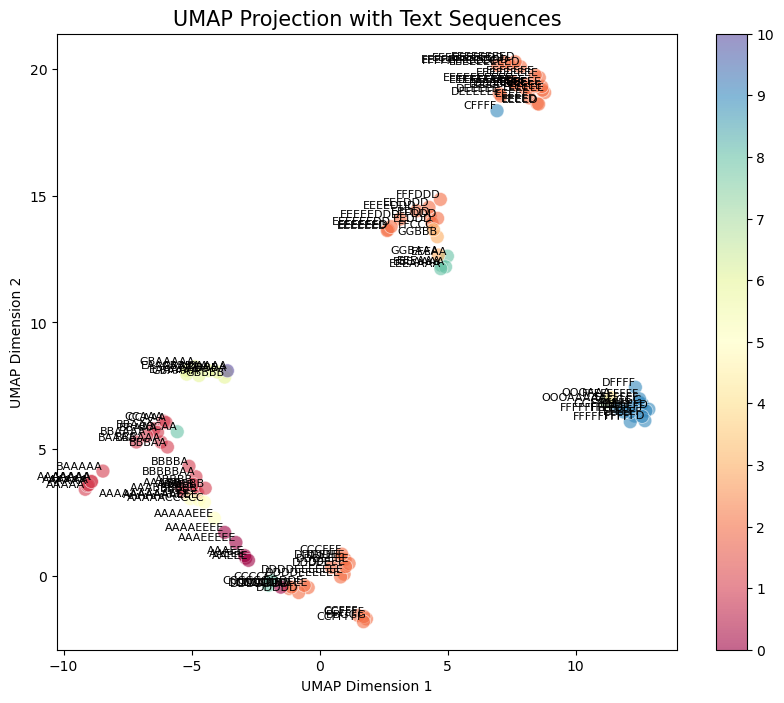

In [55]:
from sklearn.impute import SimpleImputer
# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_filled = imputer.fit_transform(X_train)


# Clustering with K-means
kmeans = KMeans(n_clusters=n_clusters, random_state=111)
y_pred = kmeans.fit_predict(X_filled.T)  # Ensure correct orientation if needed

# Apply UMAP
umap_reducer = UMAP(n_neighbors=5, min_dist=0.3, random_state=111)
umap_embedding = umap_reducer.fit_transform(X_filled.T)

# Plotting the UMAP embedding with text annotations
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=y_pred, cmap='Spectral', s=100, edgecolors='white', linewidth=0.6, alpha=0.6)
plt.colorbar(scatter, ticks=np.arange(n_clusters))
plt.title('UMAP Projection with Text Sequences', fontsize=15)

# Annotate each point with its corresponding text sequence
for i, text in enumerate(data_lst):
    plt.annotate(text, (umap_embedding[i, 0], umap_embedding[i, 1]), fontsize=8, ha='right', va='bottom')

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

/Users/schona/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/schona/anaconda3/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


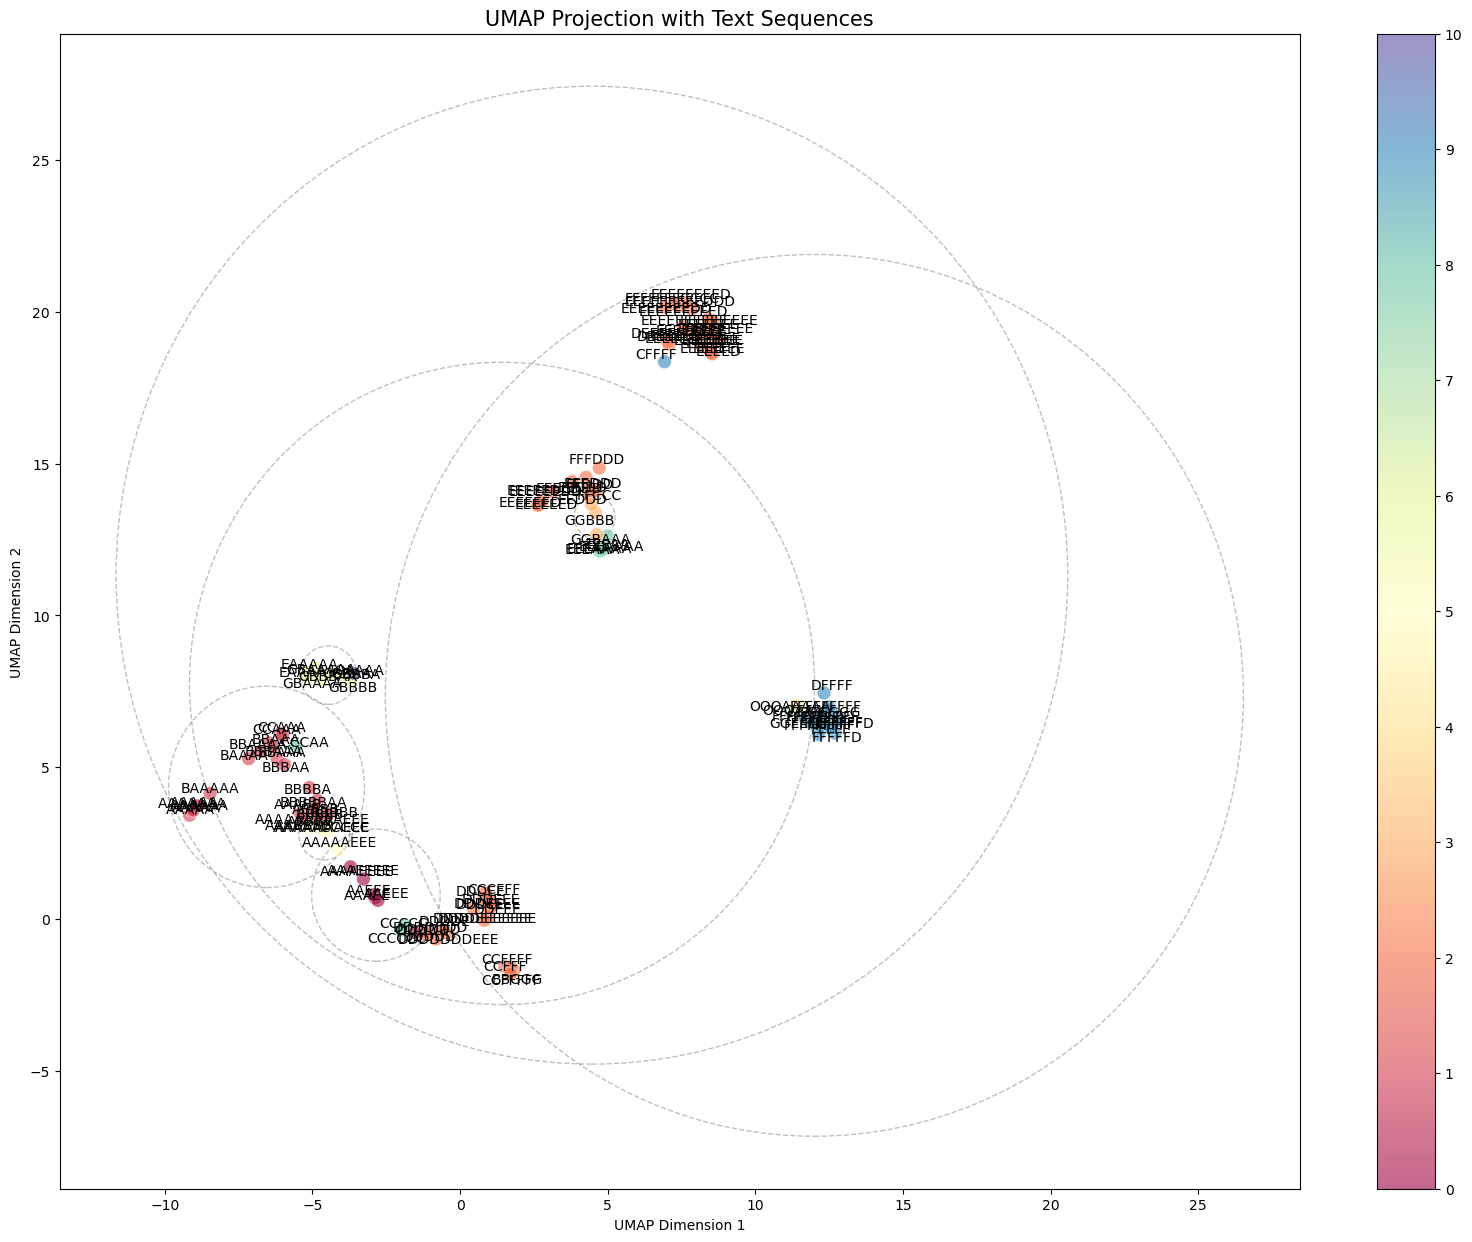

In [78]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from umap import UMAP
from sklearn.impute import SimpleImputer
import numpy as np

from sklearn.impute import SimpleImputer
# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_filled = imputer.fit_transform(X_train)


# Clustering with K-means
kmeans = KMeans(n_clusters=n_clusters, random_state=111)
y_pred = kmeans.fit_predict(X_filled.T)  # Ensure correct orientation if needed

# Apply UMAP
umap_reducer = UMAP(n_neighbors=5, min_dist=0.3, random_state=111)
umap_embedding = umap_reducer.fit_transform(X_filled.T)

# Plotting the UMAP embedding with text annotations
plt.figure(figsize=(20, 15))

# Calculate the 2D centroids of the clusters in the UMAP reduced space
centroids = np.array([umap_embedding[y_pred == k].mean(axis=0) for k in range(n_clusters)])

# Draw semi-transparent circles around the centroids of the clusters
for i, centroid in enumerate(centroids):
    cluster_points = umap_embedding[y_pred == i]
    # Find the radius of the cluster as the max distance from the centroid to the cluster points
    radius = np.sqrt(((cluster_points - centroid) ** 2).sum(axis=1)).max()
    circle = plt.Circle(centroid, radius*1.2, color='gray', fill=False, linestyle='--', alpha=0.5)
    plt.gca().add_patch(circle)

scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=y_pred, cmap='Spectral', s=100, edgecolors='white', linewidth=0.6, alpha=0.6)
plt.colorbar(scatter, ticks=np.arange(n_clusters))

# Jitter the position of text annotations to minimize overlap
# You can adjust the magnitude of jittering based on your plot
# Adjust the jittering magnitude. Smaller values will result in less offset.
jitter_magnitude_x = 0.1  # adjust the jitter magnitude for the x-axis
jitter_magnitude_y = 0.1  # adjust the jitter magnitude for the y-axis

# Calculate the range for jittering to avoid placing text too far from the corresponding point
# jitter_x = jitter_magnitude * (np.max(umap_embedding[:, 0]) - np.min(umap_embedding[:, 0]))
# jitter_y = jitter_magnitude * (np.max(umap_embedding[:, 1]) - np.min(umap_embedding[:, 1]))
jitter_x = jitter_magnitude 
jitter_y = jitter_magnitude

# Increase this value to enlarge the text size in the plot
text_size = 10

# Annotate each point with its corresponding text sequence
for i, text in enumerate(data_lst):
    offset_x = np.random.uniform(-jitter_x, jitter_x)
    offset_y = np.random.uniform(-jitter_y, jitter_y)
    plt.annotate(text, 
                 (umap_embedding[i, 0] + offset_x, umap_embedding[i, 1] + offset_y), 
                 fontsize=text_size, ha='center', va='center')
    
    
plt.title('UMAP Projection with Text Sequences', fontsize=15)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()


In [96]:
clustered_sequences=motif_init2class_df(input_path="./init_concat.csv", n_clusters=11)

Duration: 0:00:06.522428


In [97]:
clustered_sequences

,Cluster,LetterSequence
0,0,"[KDDDDDDD, DDDDDDDEEE, DDDEE, DDDDD, DDDDEEEEE..."
1,1,"[CCCAA, BBBBA, AAAAA, BBAAAA, BBAAA, CCAAA, BA..."
2,2,"[OAAAA, OOOAAA, OOOAAAAA]"
3,3,"[GBBBB, GGBBB, GBBAA, GGBAAA, GBAAAAA, GBBBAA,..."
4,4,"[FFFFFFFFF, FFFFF, FFFFFFF, DFFFF, FFFFFFFFFFF..."
5,5,"[AAAAAEEE, AAEEE, AAAAEEEE, AAAEEEEE, AAAEE, A..."
6,6,"[EEEEEEDD, EEEEEEEEDD, EEEEEEED, EEEED, EEEED,..."
7,7,"[EEEAAAA, EEEAA, EAAAAA, EEEAAA, EEEAAAA, EAAAA]"
8,8,"[FFFFFFFCCCC, FFDDD, FFFDDD, FFFFFFD, FFCCC, F..."
9,9,"[CBBGGG, CCFFFF, CFFFF, CCCFFF, LCCFFF, CCFFFF..."


In [ ]:
clustered_sequences=motif_init2class_df(input_path="./init_concat.csv", n_clusters=11)

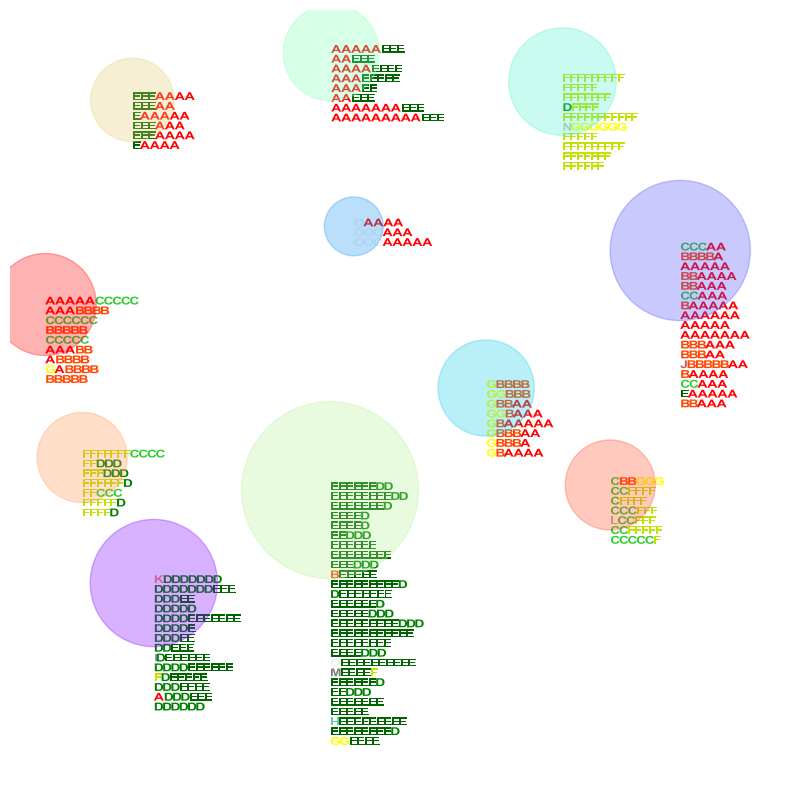

In [252]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.textpath import TextPath
from matplotlib.patches import PathPatch
import matplotlib.transforms as transforms
import networkx as nx
import numpy as np
import pandas as pd



scale_factor = 0.004  # Adjust this to change the font size

def create_text_patch(x, y, text, state_col_dict_num, ax, scale_factor):
    # Determine the starting x position for the first letter
    x_offset = x
    for letter in text:
        color = state_col_dict_num.get(letter, (0, 0, 0))
        fp = FontProperties(family="Arial", weight="bold")
        tp = TextPath((0, 0), letter, prop=fp)
        tp_transformed = transforms.Affine2D().scale(scale_factor).translate(x_offset, y) + ax.transData
        letter_patch = PathPatch(tp, color=color, lw=0, transform=tp_transformed)
        ax.add_patch(letter_patch)
        # Get the width of the letter and add a small margin
        letter_width = tp.get_extents().width * scale_factor
        x_offset += letter_width  # Increment the x position by the width of the letter

df = clustered_sequences

fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# Create a graph
G = nx.Graph()
for index, row in df.iterrows():
    G.add_node(row['Cluster'], elements=row['LetterSequence'])

# Significantly increase the base size for each node
base_node_size = 600  # This increases the node size
node_sizes = [len(elements) * base_node_size for elements in df['LetterSequence']]

# Generate a color palette with a unique color for each node
colors = plt.cm.rainbow(np.linspace(0, 1, len(df)))
# colors = plt.cm.Paired(np.linspace(0, 1, len(df)))
# colors = plt.cm.Accent(np.linspace(0, 1, len(df)))


np.random.seed(95)
# Draw the graph with a spring layout
# Adjust k to manage the distance between nodes, which can be smaller since nodes can overlap
pos = nx.spring_layout(G, k=0.05, iterations=10)


# Draw the nodes themselves
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=colors, alpha=0.3)

# Draw the text
for node, (node_pos, elements) in enumerate(zip(pos.values(), df['LetterSequence'])):
    x_start, y_start = node_pos
    for i, element in enumerate(elements):
        y_position = y_start - (i * scale_factor * 9)  # Adjust line spacing
        create_text_patch(x_start, y_position, element, state_col_dict_num, ax, scale_factor)


plt.axis('off')
plt.show()


In [256]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.textpath import TextPath
from matplotlib.patches import PathPatch
import matplotlib.transforms as transforms
import networkx as nx
import numpy as np
import pandas as pd

def motif_init2cluster_vis(input_path="./init_concat.csv", n_clusters=11, random_state=95, font_scale=0.004,font_v_scale=9, fig_w=10, fig_h=10, node_size=600, node_dist=0.05):
    clustered_sequences=motif_init2class_df(input_path=input_path, n_clusters=n_clusters)
    scale_factor = font_scale  # Adjust this to change the font size

    def create_text_patch(x, y, text, state_col_dict_num, ax, scale_factor):
        # Determine the starting x position for the first letter
        x_offset = x
        for letter in text:
            color = state_col_dict_num.get(letter, (0, 0, 0))
            fp = FontProperties(family="Arial", weight="bold")
            tp = TextPath((0, 0), letter, prop=fp)
            tp_transformed = transforms.Affine2D().scale(scale_factor).translate(x_offset, y) + ax.transData
            letter_patch = PathPatch(tp, color=color, lw=0, transform=tp_transformed)
            ax.add_patch(letter_patch)
            # Get the width of the letter and add a small margin
            letter_width = tp.get_extents().width * scale_factor
            x_offset += letter_width  # Increment the x position by the width of the letter

    df = clustered_sequences

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))  # Adjust figure size as needed

    # Create a graph
    G = nx.Graph()
    for index, row in df.iterrows():
        G.add_node(row['Cluster'], elements=row['LetterSequence'])

    # Significantly increase the base size for each node
    base_node_size = node_size  # This increases the node size
    node_sizes = [len(elements) * base_node_size for elements in df['LetterSequence']]

    # Generate a color palette with a unique color for each node
    colors = plt.cm.rainbow(np.linspace(0, 1, len(df)))

    np.random.seed(random_state)
    # Draw the graph with a spring layout
    # Adjust k to manage the distance between nodes, which can be smaller since nodes can overlap
    pos = nx.spring_layout(G, k=node_dist, iterations=10)

    # Draw the nodes themselves
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=colors, alpha=0.3)

    # Draw the text
    for node, (node_pos, elements) in enumerate(zip(pos.values(), df['LetterSequence'])):
        x_start, y_start = node_pos
        for i, element in enumerate(elements):
            y_position = y_start - (i * scale_factor * font_v_scale)  # Adjust line spacing
            create_text_patch(x_start, y_position, element, state_col_dict_num, ax, scale_factor)

    ############################## Save the figure
    fig.savefig('./test_cluster.png', bbox_inches='tight', dpi=300)
    plt.axis('off')
    plt.show()


Duration: 0:00:06.704702


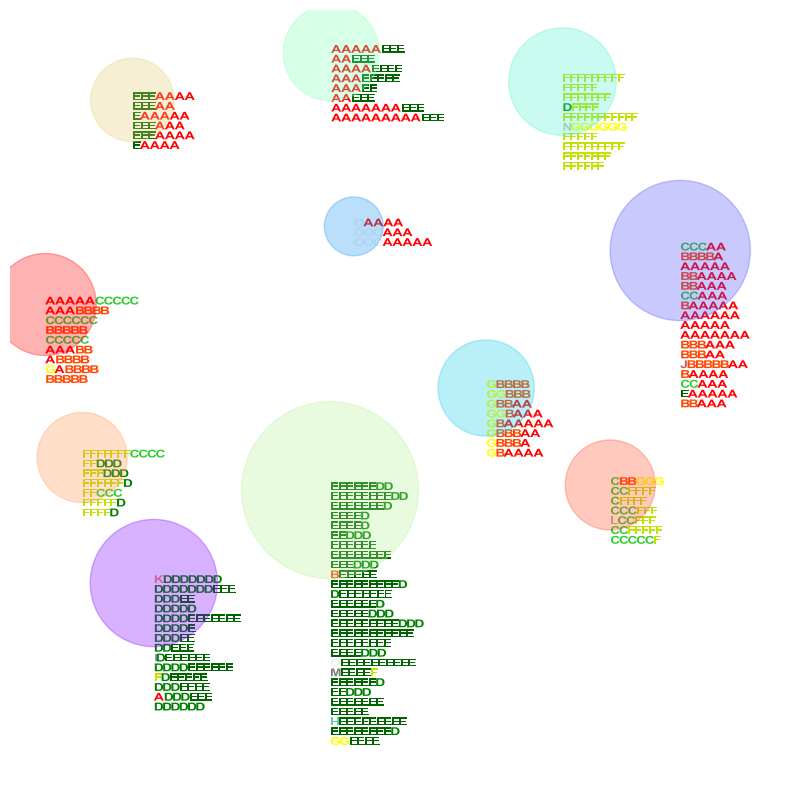

In [257]:
motif_init2cluster_vis(input_path="./init_concat.csv")

In [3]:
import numpy as np
import pandas as pd
import tslearn
from tslearn.clustering import TimeSeriesKMeans
from datetime import datetime
import matplotlib.pyplot as plt
from pylab import rcParams

In [4]:
path_0n20="./network_test/dtw/prom/not_n_rpkm20/cp1_init_df.csv"
path_0n30="./network_test/dtw/prom/not_n_rpkm30/cp1_init_df.csv"
path_0n50="./network_test/dtw/prom/not_n_rpkm50/cp1_init_df.csv"

df20=pd.read_csv(path_0n20)
df30=pd.read_csv(path_0n30)
df50=pd.read_csv(path_0n50)

lst20=df20["motif"].to_list()
lst30=df30["motif"].to_list()
lst50=df50["motif"].to_list()

In [5]:
# provide users our file:
all_df=pd.concat([df20,df30,df50], axis=0)
all_df.reset_index(drop=True, inplace=True)
# len(all_df)
all_df.to_csv("./init_concat.csv")

In [6]:
def motif_init2df(input_path="./init_concat.csv"):
    """
    Read init.csv file and convert it to 
    """
    df=pd.read_csv(input_path)
    data_lst=df["motif"].to_list()
    def convert_sequence(sequence, mapping):
        return [mapping[letter] for letter in sequence]
    letter_to_num = {'A': 1,'B': 2,'C': 3,'D': 4,'E': 5,'F': 6,'G': 7,
                     'H': 8,'I': 9,'J': 10,'K': 11,'L': 12,'M': 13,'N': 14,'O': 15}
    numerical_sequences=[convert_sequence(seq, letter_to_num) for seq in data_lst]
    df_sequences = pd.DataFrame(numerical_sequences).astype('Int64').T
    # Add an 'entry' column at the beginning of the DataFrame with labels 'Entry 1', 'Entry 2', etc.
    df_sequences.insert(0, 'position', ['Pos ' + str(i+1) for i in range(df_sequences.shape[0])])
    return df_sequences



In [7]:
def motif_init2pred(input_path="./init_concat.csv", n_clusters=11):
    """
    Read init.csv file and directly predict the class using DTW and k-mean
    """
    from tslearn.metrics import dtw

    df_sequences=motif_init2df(input_path=input_path)
    X_train = df_sequences.loc[:, df_sequences.columns != 'position']
    # Fill missing values with zero
    X_train_filled = X_train.fillna(0)
    # Then proceed with the DTW distance matrix computation
    n_series = X_train_filled.shape[0]
    dtw_distance_matrix = np.zeros((n_series, n_series))

    for i in range(n_series):
        for j in range(i, n_series):  # No need to compute the distance twice for (i, j) and (j, i)
            distance = dtw(X_train_filled[i], X_train_filled[j])
            dtw_distance_matrix[i, j] = distance
            dtw_distance_matrix[j, i] = distance
    seed=111
    start_time = datetime.now()
    # print("DTW k-means")
    dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
        n_init=10, #2,  # number of time you run with different initial centroid 
        metric="dtw",
        verbose=False, #True,
        max_iter_barycenter=10,
        random_state=seed)
    y_pred = dba_km.fit_predict(X_train.T)
    # print(y_pred)
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    return y_pred

In [8]:
y_pred=motif_init2pred()
y_pred

Duration: 0:00:11.401807


array([ 6,  0,  6,  9,  6,  1,  0, 10,  6,  0,  1,  0,  9,  6,  4,  6,  0,
        6, 10,  6,  6,  0,  6,  0,  6,  5, 10,  0, 10,  3,  7,  4,  3,  9,
        6,  4,  8,  7,  0,  2,  6,  6,  5,  5,  1,  6,  0,  7,  6,  4,  4,
        4,  0, 10,  6,  2,  3, 10,  6,  6,  6,  9, 10,  9, 10,  1,  6,  5,
        1,  6,  4,  3,  0,  1,  3,  8,  1,  1,  1,  5,  6,  1,  6,  4,  4,
        1,  5,  6,  8,  8,  0,  6,  1,  2,  1,  7,  3,  6,  7,  1,  0,  7,
        8,  9,  4,  5,  3,  9,  3,  1,  5,  8,  8, 10,  1,  1])

In [9]:
from tqdm.notebook import tqdm  # Import the notebook version of tqdm

def motif_init2elbow(input_path="./init_concat.csv", n_start=1, n_end=25):
    df_sequences = motif_init2df(input_path=input_path)
    X_train = df_sequences.loc[:, df_sequences.columns != 'position']
    n_cluster_range = range(n_start, n_end + 1)
    inertia = []
    seed = 111
    
    # Wrap n_cluster_range with tqdm for the progress bar
    for n_clusters in tqdm(n_cluster_range, desc="Calculating clusters"):
        model = TimeSeriesKMeans(n_clusters=n_clusters,
                                 metric="dtw",
                                 verbose=False,
                                 max_iter_barycenter=10,
                                 random_state=seed)
        model.fit(X_train.T)
        inertia.append(model.inertia_)
        # The tqdm progress bar replaces the need for the print statement
        
    # Filter out infinite values and their corresponding cluster numbers
    finite_inertia = [i for i in inertia if np.isfinite(i)]
    n_cluster_finite = list(n_cluster_range)[:len(finite_inertia)]

    # Plotting the inertia with finite values only
    plt.figure(figsize=(12, 6))
    plt.plot(n_cluster_finite, finite_inertia, marker='o')
    plt.title('Elbow Method For Optimal Cluster Number', fontsize=16)
    plt.xlabel('Number of clusters', fontsize=16)
    plt.ylabel('Inertia', fontsize=16)
    plt.xticks(n_cluster_finite, fontsize=12)  # Increase x-axis ticks font size
    plt.yticks(fontsize=12)
    plt.grid()
    plt.show()


Calculating clusters:   0%|          | 0/25 [00:00<?, ?it/s]

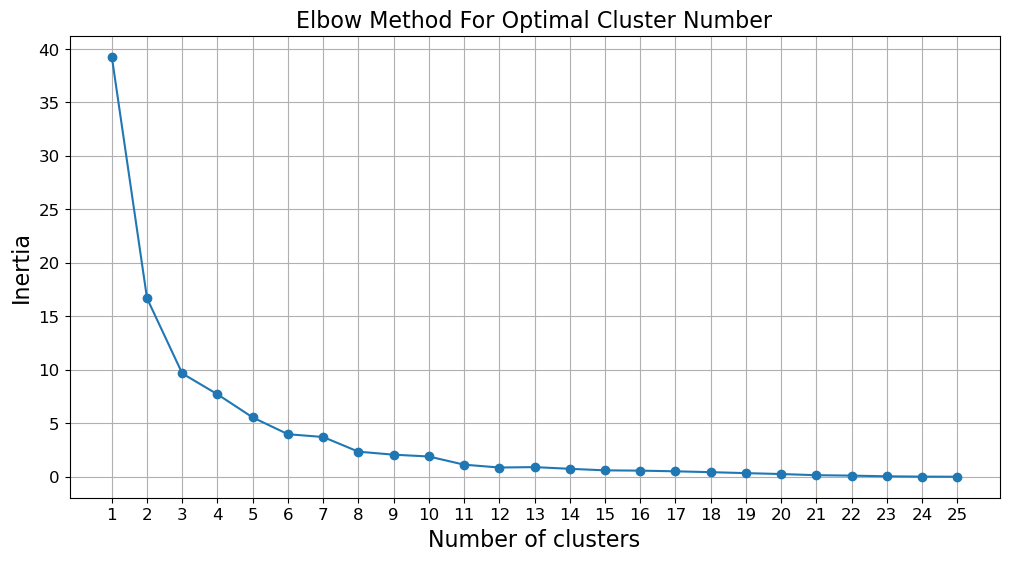

In [10]:
motif_init2elbow()

In [11]:
def motif_init2class_df(input_path="./init_concat.csv", n_clusters=11):
    df_sequences=motif_init2df(input_path=input_path)

    # Transpose df_test so that each entry becomes a row
    df_seq_transposed = df_sequences.T  
    # The first row will likely contain something other than data (e.g., time points), so let's keep it as a header
    new_header = df_seq_transposed.iloc[0]  # Grab the first row for the header
    df_seq_transposed = df_seq_transposed[1:]  # Take the data less the header row
    df_seq_transposed.columns = new_header  # Set the header row as the df header
    # Reset the index to make the entries into a column
    df_seq_transposed.reset_index(inplace=True)
    # Rename the 'index' column to something more descriptive, like 'Entry'
    df_seq_transposed.rename(columns={'index': 'Entry'}, inplace=True)

    y_pred=motif_init2pred(input_path=input_path, n_clusters=n_clusters)

    # Add the cluster labels as a new column
    df_seq_transposed['Cluster'] = y_pred
    # Sort the DataFrame by the 'Cluster' column
    df_sorted_by_cluster = df_seq_transposed.sort_values(by='Cluster')
    # Reset the index of the sorted DataFrame
    df_sorted_by_cluster.reset_index(drop=True, inplace=True)
    # Display the sorted DataFrame
    # df_sorted_by_cluster
    # Reverse the letter_to_num mapping
    letter_to_num = {'A': 1,'B': 2,'C': 3,'D': 4,'E': 5,'F': 6,'G': 7,
                        'H': 8,'I': 9,'J': 10,'K': 11,'L': 12,'M': 13,'N': 14,'O': 15}
    num_to_letter = {v: k for k, v in letter_to_num.items()}

    # Function to convert a series of numbers to a letter string, ignoring NaNs
    def series_to_letters(series):
        return ''.join([num_to_letter.get(x, '') for x in series if pd.notna(x)])

    # Apply the conversion to each row (excluding the 'Cluster' column) and add the result to a new column
    df_sorted_by_cluster['LetterSequence'] = df_sorted_by_cluster.drop('Cluster', axis=1).apply(series_to_letters, axis=1)

    # Group by 'Cluster' and aggregate 'LetterSequence' into lists
    clustered_sequences = df_sorted_by_cluster.groupby('Cluster')['LetterSequence'].apply(list).reset_index()

    # Display the result
    return clustered_sequences

In [12]:
clustered_sequences=motif_init2class_df()

Duration: 0:00:10.776730


In [13]:
clustered_sequences

,Cluster,LetterSequence
0,0,"[KDDDDDDD, DDDDDDDEEE, DDDEE, DDDDD, DDDDEEEEE..."
1,1,"[CCCAA, BBBBA, AAAAA, BBAAAA, BBAAA, CCAAA, BA..."
2,2,"[OAAAA, OOOAAA, OOOAAAAA]"
3,3,"[GBBBB, GGBBB, GBBAA, GGBAAA, GBAAAAA, GBBBAA,..."
4,4,"[FFFFFFFFF, FFFFF, FFFFFFF, DFFFF, FFFFFFFFFFF..."
5,5,"[AAAAAEEE, AAEEE, AAAAEEEE, AAAEEEEE, AAAEE, A..."
6,6,"[EEEEEEDD, EEEEEEEEDD, EEEEEEED, EEEED, EEEED,..."
7,7,"[EEEAAAA, EEEAA, EAAAAA, EEEAAA, EEEAAAA, EAAAA]"
8,8,"[FFFFFFFCCCC, FFDDD, FFFDDD, FFFFFFD, FFCCC, F..."
9,9,"[CBBGGG, CCFFFF, CFFFF, CCCFFF, LCCFFF, CCFFFF..."


In [14]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

def motif_init2class_vis(input_path="./init_concat.csv", n_clusters=11):
    df_sequences=motif_init2df(input_path=input_path)
    y_pred=motif_init2pred(input_path=input_path, n_clusters=n_clusters)

    from itertools import cycle

    # Set the figure size and legend location
    rcParams["figure.figsize"] = 12, 6
    rcParams["legend.loc"] = 'upper right'

    # Assuming df_test is your DataFrame and y_pred is your array of predicted cluster labels
    item_list = df_sequences.columns.tolist()[1:]

    cluster_colors = {
        0: (0.12, 0.47, 0.71),    # Blue
        1: (0.68, 0.78, 0.91),    # Light Blue
        2: (1.0, 0.50, 0.05),     # Orange
        3: (1.0, 0.73, 0.47),     # Light Orange
        4: (0.17, 0.63, 0.17),    # Green
        5: (0.60, 0.87, 0.54),    # Light Green
        6: (0.84, 0.15, 0.16),    # Red
        7: (1.0, 0.60, 0.59),     # Light Red
        8: (0.58, 0.40, 0.74),    # Purple
        9: (0.77, 0.69, 0.84),    # Light Purple
        10: (0.55, 0.34, 0.29)    # Brown
    }

    # Define a list of linestyles
    linestyles = ['-', '--', '-.', ':']

    # Create a cycle object from the linestyles list
    linestyle_cycle = cycle(linestyles)

    # Assign a linestyle to each cluster, cycling through the available styles
    cluster_linestyles = {i: next(linestyle_cycle) for i in range(n_clusters)}

    # Create a figure and a subplot
    fig, ax = plt.subplots()

    # Plot each item with its corresponding color and line style
    for index, item in enumerate(item_list):
        color = cluster_colors[y_pred[index]]
        linestyle = cluster_linestyles[y_pred[index]]
        ax.plot(df_sequences["position"], df_sequences[item].astype('float'), 
                label=str(item)+"_cluster"+str(y_pred[index]), 
                color=color, linestyle=linestyle)

    # Set x-tick labels with rotation
    ax.set_xticks(df_sequences["position"])
    ax.set_xticklabels(df_sequences["position"].astype(str), rotation=45)

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()


In [49]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

def motif_init2class_vis(input_path="./init_concat.csv", categorical=False, n_clusters=11):
    df_sequences = motif_init2df(input_path=input_path)
    y_pred = motif_init2pred(input_path=input_path, categorical=categorical, n_clusters=n_clusters)

    from itertools import cycle

    # Set the figure size and legend location
    rcParams["figure.figsize"] = (12, 6)
    rcParams["legend.loc"] = 'upper right'

    # Assuming df_sequences is your DataFrame and y_pred is your array of predicted cluster labels
    item_list = df_sequences.columns.tolist()[1:]

    # Define a list of linestyles
    linestyles = ['-', '--', '-.', ':']

    # Create a cycle object from the linestyles list
    linestyle_cycle = cycle(linestyles)

    # Assign a linestyle to each cluster, cycling through the available styles
    cluster_linestyles = {i: next(linestyle_cycle) for i in range(n_clusters)}

    # Create a figure and a subplot
    fig, ax = plt.subplots()

    # Plot each item with its corresponding color (automatically determined by matplotlib) and line style
    for index, item in enumerate(item_list):
        linestyle = cluster_linestyles[y_pred[index]]
        ax.plot(df_sequences["position"], df_sequences[item].astype('float'), 
                label=f"{item}_cluster{y_pred[index]}", 
                linestyle=linestyle)

    # Set x-tick labels with rotation
    ax.set_xticks(df_sequences["position"])
    ax.set_xticklabels(df_sequences["position"].astype(str), rotation=45)

    # Add a legend
    # plt.legend()

    # Show the plot
    plt.show()


In [50]:
motif_init2class_vis(categorical=True)

NameError: name 'motif_init2pred' is not defined

Duration: 0:00:12.498057


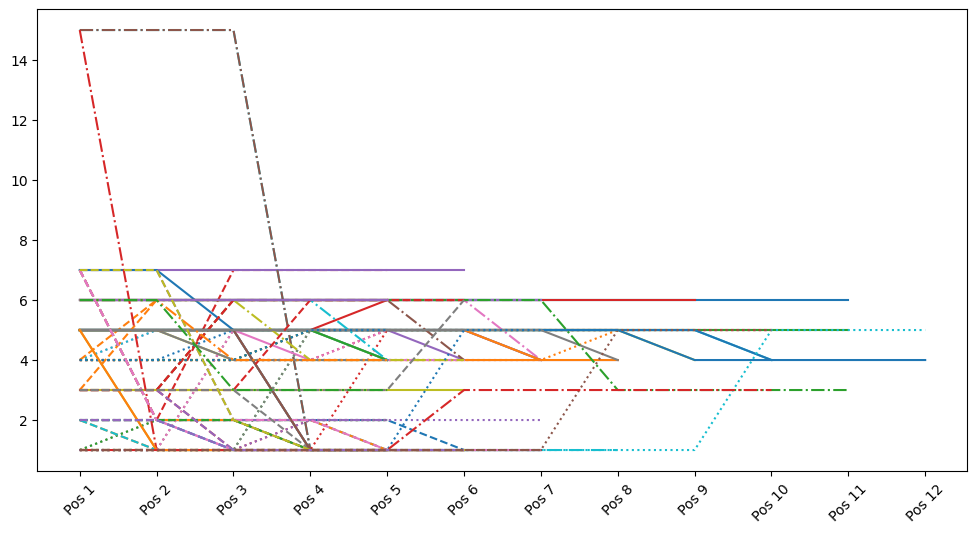

In [16]:
motif_init2class_vis(n_clusters=14)

In [27]:
def motif_init2umap(input_path="./init_concat.csv", n_clusters=11, n_neighbors=5, min_dist=0.3, random_state=111):
    """
    Generate a UMAP embedding of the given data.

    Parameters:

    - input_path: .csv file of all motifs with high attention score
    
    - n_clusters: number of clusters

    - n_neighbors: int (default=5), The size of local neighborhood (in terms of number of neighboring sample points) 
      used for manifold approximation. Larger values result in a more global view of the manifold, while smaller values emphasize local data structures. 
      Adjust according to the desired granularity of the embedding.
      
    - mid_dist: float (default=0.3), The minimum distance between embedded points in the low-dimensional space. 
      Smaller values allow points to cluster more tightly in the embedding, which is useful for identifying finer substructures within the data. 
      Larger values help preserve the overall topology of the data by preventing points from clustering too tightly.
    """
    df_sequences = motif_init2df(input_path=input_path)
    X_train = df_sequences.loc[:, df_sequences.columns != 'position']
    X_train = X_train.astype('float64')  # Convert to float64
    X_filled = X_train.fillna(X_train.mean())

    y_pred = motif_init2pred(input_path=input_path, n_clusters=n_clusters)

    # Now apply UMAP on the cleaned data
    from umap import UMAP
    # # seed=111
    # # umap_reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=seed)
    # umap_reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist)
    umap_reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state, n_jobs=1)

    umap_embedding = umap_reducer.fit_transform(X_filled.T)  # Ensure the data is transposed if necessary

    plt.figure(figsize=(8, 5))
    scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=y_pred, cmap='Spectral', s=100, edgecolors='white', linewidth=0.6)

    # Create a color bar with ticks for each cluster label
    colorbar = plt.colorbar(scatter, ticks=np.arange(0, 11))
    colorbar.set_label('Cluster label')

    # Set the plot title and labels
    plt.title('UMAP Projection After K-means clustering', fontsize=20)
    plt.xlabel('UMAP Dimension 1', fontsize=15)
    plt.ylabel('UMAP Dimension 2', fontsize=15)

    # Show the plot
    plt.show()

Duration: 0:00:11.033547


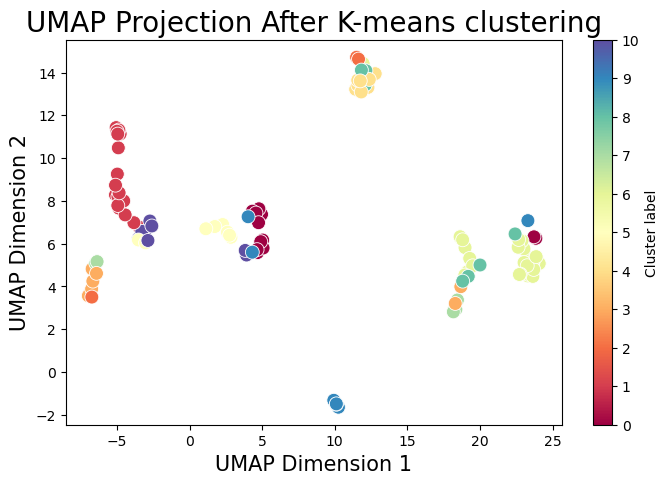

In [28]:
motif_init2umap()

In [4]:
from css_utility import *
import ast

In [12]:
crp_df["A"][0]

0.1836419753086419

In [ ]:
          G         B         B         B         G
0  0.037423  0.000000  0.000000  0.000000  0.000000
1  0.000000  0.056624  0.000000  0.000000  0.000000
2  0.000000  0.000000  0.042596  0.000000  0.000000
3  0.000000  0.000000  0.000000  0.044513  0.000000
4  0.000000  0.000000  0.000000  0.000000  0.035308

In [11]:
original_df = pd.DataFrame({
    'G': [0.037423, 0, 0, 0, 0],
    'B': [0, 0.056624, 0, 0, 0],
    'B': [0, 0, 0.042596, 0, 0],
    'B': [0, 0, 0, 0.044513, 0],
    'G': [0, 0, 0, 0, 0.035308]
})

# Transpose the DataFrame to separate the rows by characters
transposed_df = original_df.T
# Create individual DataFrames for each character
g_df = transposed_df.loc['G'].T
b_df = transposed_df.loc['B'].T

# Reset column names to be unique
g_df.columns = [f'G{i}' for i in range(len(g_df.columns))]
b_df.columns = [f'B{i}' for i in range(len(b_df.columns))]

AttributeError: 'Series' object has no attribute 'columns'

In [10]:
transposed_df

,0,1,2,3,4
G,0.0,0.0,0.0,0.000000,0.035308
B,0.0,0.0,0.0,0.044513,0.000000


In [2]:
path="../database/roadmap/prom/up2kdown4k/all_genes/E003_prom_up2kdown4k.pkl"
with open(path, "rb") as f:
    data=pickle.load(f)

In [4]:
len(data[0])

2060

In [8]:
test_data=data[0][40:60]

In [13]:
colored_css_str_as_is(test_data[0])

EGGGBAAAAAAAABBEEEEEEEEDDDDEEE


In [14]:
for item in test_data:
    colored_css_str_as_is(item)

EGGGBAAAAAAAABBEEEEEEEEDDDDEEE
EHHHEEEEEEEEEEEEEEEEEEEEEEEEEE
EEEEBBGGGGGGGGGBKKKKKKJJKKLLGG
GGEEEEEDDFBBBAAAAAAAAAAAEEEEEE
EEEEEEEDDDDDDDDDDDDDDDDDDDDDDD
DFCCCAAAAAAAABBBFFFFFFFFDDDDDD
EEEEEEEEEEEEEEGGGBAABGGGGGGGGG
EEEEEEGGGGGGGEEEAAAEHEEEEEEEGG
HEEEEEEEGGGGGGGGGGGGGGGGGGGGGB
GGBBBBBBBBAAABKKGEEEEEEEEEDDDD
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
OOOOAAAAAAAAAAAAAEEEEEEEEEEEEE
OOOOAAAAAAAAAAAGGGEEEEEEEEEEEE
EEEEEEEEEEEEDEEEEEEEEEEEEDDDEE
AAAAAABBFDDDDDDDDDDDDDDDDDDDDD
MMMMLLLLLLLLLLLKKJJJJJJKLMMMMM
OOOOAAAAAAAAAAABBGEEEEEEEEEEEE
MJJJJJJJJJJJEEEEEEEEEEEEEEEEEE
EEEEEEEEEEEEEEEEDDDDDDEEEEEEEE
EEAAAAAAAAAAEEEEEEEEEEEEEEEEEE


In [136]:
def extract_numbers(s):
    numbers = re.findall('\d+', s)
    numbers = [int(number) for number in numbers]
    return numbers

In [118]:
def convert_to_array(s):
    # Find all arrays in the string
    arrays_str = re.findall(r'array\(\[.*?\]\)', s.replace('\n', ''))

    arrays = []
    for arr_str in arrays_str:
        # Remove 'array([' from the start and '])' from the end
        s_trimmed = arr_str[7:-2]
        # Convert string to array
        array = np.fromstring(s_trimmed, sep=',')
        arrays.append(array)
    
    return arrays

In [143]:
def read_motif_score_file(path):
    df_raw=pd.read_csv(path, header=None)
    df=df_raw.T
    df=df.dropna()
    df.columns=["seq", "index", "position", "score"]
    df=df[["index", "position","seq","score"]]
    df["index"]=df["index"].apply(extract_numbers)
    df["position"]=df["position"].apply(ast.literal_eval)
    df["score"]=df["score"].apply(convert_to_array)
    return df

In [167]:
def filtered_motif_n_score(score_path,filter_path):
    """
    score_path: the file for extracting motif and corresponding attention scores
    filter_path: the file consists of "motif", "N", "K", "n", "x", "p"
    """
    # motif scores are extracted for "all high attention area" meets the conditions
    df=read_motif_score_file(score_path)
    # filter is for p<0.05
    fil_df=pd.read_csv(filter_path)
    fil_df.rename(columns={'motif': 'seq'}, inplace=True)
    df_merged=pd.merge(df, fil_df, on="seq")
    return df_merged

In [168]:
df_merged=filtered_motif_n_score(score_path="test_extract_df.csv",filter_path="init_df.csv")

In [173]:
df_merged["seq"].unique()

array(['EDDDDDDDDD', 'GGEEGE', 'EDDDDEE', 'MMMMLL', 'JJJJJJMM', 'EEDDD',
       'GGGEEGE', 'GGBGBGG', 'JJJJM', 'GBBGGG', 'EEGEEEE', 'JJJJJM',
       'JJJJJJJJJ', 'EEDDDDDDDEE', 'EDDDDDEE', 'EEDDEE', 'EEEDDD',
       'EEDDDD', 'AAABEE', 'KKLLL', 'AABBEE', 'EEEEE', 'MJJJJJ', 'GGBBAA',
       'EEDEEE', 'GGBGEE', 'GGGEE', 'AAABGEE', 'JJJJJJ', 'AAABBEEE',
       'EEEDDDDDD', 'EEEDDDDDEE', 'EEDDDDDDDDDDDD', 'EEEDDDDDDDEE',
       'EEEDDDE', 'EEDDDDEE', 'GGBGGG', 'ABBGGG', 'AAABEEE', 'EEGGGG',
       'EEDDDEEEEE', 'AAAAB', 'AAAAA', 'HDDDD', 'EDDDDDDDDDDDDDD',
       'AAAAGEEE', 'AAAAAAAA', 'EEEEEEDDD', 'EEEGGGGGGG', 'LMMMM',
       'DDDDDDDD', 'AABEE', 'EEEEEEEE', 'BGGGGGGG', 'EEEEEEEEEEEEE',
       'DDDDDDD', 'HHHHHHH', 'EEEEEE', 'EEEEEEEEEDDDDE', 'EEEEGG',
       'EEEEEEDD', 'BEEEEEE', 'MMJJJJ', 'LLLKK', 'EEEEEEEEEEEE', 'EEEDD',
       'DDDDDDDDDEEE', 'EEEEEEED', 'DDDDD', 'GGGGGGGGE', 'BGEEE',
       'EEEEEEE', 'AAAAAAABB', 'EEEEEEEEEEEEEGG', 'EEEEEGGGEEEE',
       'EEDDDDDEE', 'ABBGEEEEE',

In [203]:
def extStrong_prom(prom_path="../database/roadmap/prom/up2kdown4k/gene_exp/", rpkm_val=50, chromatin_state="A"):#, output_path=):
    """Gather the strong promoter regions at once"""
    prom_path_subdir=os.listdir(prom_path)
    prom_path_tardir=[os.path.join(prom_path, subdir) for subdir in prom_path_subdir if str(rpkm_val) in subdir][0]
    if rpkm_val==0:
        prom_path_tardir=os.path.join(prom_path, "rpkm0")
        
    prom_files=sorted([os.path.join(prom_path_tardir,file) for file in os.listdir(prom_path_tardir)])
    
    strong_prom_all=[]
    for file in prom_files:
        cell_id=file.split("/")[-1][:4]
        if cell_id=="E004":break ## for test
        with open(file,"rb") as f:
            prom_lst_chr=pickle.load(f) # list by chromosome
        prom_all=flatLst(prom_lst_chr) # flattened, now a list of strings (prom)
        strong_prom=[]
        for prom in prom_all:
            if chromatin_state in prom:
                strong_prom.append(prom)
        strong_prom_all.append(strong_prom)
    strong_prom_all=flatLst(strong_prom_all)
    return strong_prom_all

In [205]:
def extWeak_prom(prom_path="../database/roadmap/prom/up2kdown4k/gene_exp/not_exp/", chromatin_state="A"):#, output_path=):
    """Gather the Weak promoter regions at once"""   
    prom_files=sorted([os.path.join(prom_path,file) for file in os.listdir(prom_path)])
    
    weak_prom_all=[]
    for file in prom_files:
        cell_id=file.split("/")[-1][:4]
        if cell_id=="E004":break ## for test
        with open(file,"rb") as f:
            prom_lst_chr=pickle.load(f) # list by chromosome
        prom_all=flatLst(prom_lst_chr) # flattened, now a list of strings (prom)
        weak_prom_all=[]
        for prom in prom_all:
            if chromatin_state in prom:
                weak_prom.append(prom)
        weak_prom_all.append(weak_prom)
    weak_prom_all=flatLst(weak_prom_all)
    return weak_prom_all

In [189]:
prom_test="../database/roadmap/prom/up2kdown4k/gene_exp/rpkm50/E003_prom_up2kdown4k.pkl"

In [190]:
with open(prom_test,"rb") as f:
    data=pickle.load(f)

In [196]:
data_flat=flatLst(data)

In [201]:
len(data_flat)

1229

In [35]:
#### merge_intervals # for a list of dataframe, you can run it after running Gexp_Gene2GLChr

In [43]:
gene_file_path="../database/roadmap/gene_exp/refFlat_byCellType/rpkm50/E003_gene_highlyexpressed.refFlat"

In [67]:
gene_file_path_116="../database/roadmap/gene_exp/refFlat_byCellType/rpkm50/E116_gene_highlyexpressed.refFlat"

In [79]:
with open("../database/roadmap/df_pickled/E003_df_pickled.pkl","rb") as f:
    df=pickle.load(f)

In [68]:
with open("../database/roadmap/df_pickled/E116_df_pickled.pkl","rb") as f116:
    df116=pickle.load(f116)

In [111]:
exp_gene_dir="../database/roadmap/gene_exp/refFlat_byCellType/"
exp_gene_files=os.listdir(exp_gene_dir)

In [112]:
exp_gene_files

['rpkm50', 'rpkm30', 'rpkm20', 'rpkm10', 'rpkm0']

In [115]:
exp_gene_subdir=os.listdir(exp_gene_dir)
exp_gene_tardir=[os.path.join(exp_gene_dir, subdir) for subdir in exp_gene_subdir if str(50) in subdir]

In [183]:
def extNsaveProm_g_exp(exp_gene_dir="../database/roadmap/gene_exp/refFlat_byCellType/", df_pickle_dir="../database/roadmap/df_pickled/",output_path="../database/roadmap/prom/up2kdown4k/gene_exp/",rpkm_val=50, up_num=2000, down_num=4000,unit=200):
    exp_gene_subdir=os.listdir(exp_gene_dir)
    exp_gene_tardir=[os.path.join(exp_gene_dir, subdir) for subdir in exp_gene_subdir if str(rpkm_val) in subdir][0]
    if rpkm_val==0:
        exp_gene_tardir=os.path.join(exp_gene_dir, "rpkm0")
    
    # If the directories are named something like 'subdir_0' and 'subdir_50':
#     exp_gene_tardir=[os.path.join(exp_gene_dir, subdir) for subdir in exp_gene_subdir if re.match(f'subdir_{rpkm_val}$', subdir)][0]

    exp_gene_files=sorted([os.path.join(exp_gene_tardir,file) for file in os.listdir(exp_gene_tardir)])
    
    for exp_gene_file in exp_gene_files:
        cell_id=exp_gene_file.split("/")[-1][:4]
#         if cell_id=="E004":break ## for test
        df_name=[file for file in os.listdir(df_pickle_dir) if cell_id in file][0]
        df_path=os.path.join(df_pickle_dir,df_name)
        with open(df_path,"rb") as f:
            df=pickle.load(f)
        css_prom_lst_unit_all=extProm_wrt_g_exp(exp_gene_file, df, up_num=up_num, down_num=down_num,unit=unit)
           
        output_name=output_path+"rpkm"+str(rpkm_val)+"/"+cell_id+"_prom_up2kdown4k.pkl"
        output_dir = os.path.dirname(output_name)
        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir, exist_ok=True)
        with open(output_name, "wb") as g:
            pickle.dump(css_prom_lst_unit_all,g)
    return print("Saved at ",output_path)

In [170]:
def extProm_wrt_g_exp(exp_gene_file, df, up_num=2000, down_num=4000,unit=200):
    """
    extract promoter regions of genes according to gene expression level
    """
    df = df[df['chromosome'] != 'chrM']
    g_lst_chr=Gexp_Gene2GLChr(exp_gene_file)
    g_lst_chr_merged=merge_intervals(g_lst_chr)
    
    css_prom_lst_all=prom_expGene2css(g_lst_chr_merged,df, up_num=up_num, down_num=down_num)
    css_prom_lst_unit_all=Convert2unitCSS_main_new(css_prom_lst_all, unit=unit)
    return css_prom_lst_unit_all

In [171]:
def prom_expGene2css(g_lst_chr_merged,df, up_num=2000, down_num=4000):   # df indicates css, created by bed2df_expanded
    """
    modified from `compGene2css`
    Input: Reference gene file traimmed for gene expresseion level, df (CSS)
    Output: list of chromosome-wise list that contains the css at (expressed) genic area with prom only.
    """
    g_lst_chr=g_lst_chr_merged
    df = df[df['chromosome'] != 'chrM']
    css_lst_chr=df2longcss(df) # list of long css per chromosome
    
    g_lst_chr = g_lst_chr[:len(css_lst_chr)]  # adjust the length of list according to length of df (might not have chrY)
    total_chr=len(css_lst_chr)
    
    print("Matching to the chromatin state sequence data ...")
    css_prom_lst_all=[]
    for i in tqdm_notebook(range(total_chr)):
        css=css_lst_chr[i]   # long css of i-th chromosome
        gene_df=g_lst_chr[i] # gene df of i-th chromosome
        
        css_prom_lst_chr=[]
        for j in range(len(gene_df)):
            prom_start=gene_df["TxStart"].iloc[j]-1-up_num  # python counts form 0
            prom_end=prom_start+up_num+down_num+1      # python excludes the end
            if gene_df["TxEnd"].iloc[j]<prom_end:  # if longer than gene body, then just gene body
                prom_end=gene_df["TxEnd"].iloc[j]+1
    
            css_prom=css[prom_start:prom_end]           # cut the gene area only
            css_prom_lst_chr.append(css_prom)     # store in the list
          
        css_prom_lst_all.append(css_prom_lst_chr)  # list of list
    
    assert len(css_prom_lst_all)==total_chr
    
    # remove chromosome if it is empty (e.g. chrY for female)
    css_prom_lst_all=[elm for elm in css_prom_lst_all if elm!=[]] 
    
    print("Done!")
    return css_prom_lst_all 

In [156]:
css_prom_lst_all=prom_expGene2css(exp_gene_file,df, up_num=2000, down_num=4000)

NameError: name 'exp_gene_file' is not defined

In [157]:
css_prom_lst_unit_all=extProm_wrt_g_exp('../database/roadmap/gene_exp/refFlat_byCellType/rpkm50/E003_gene_highlyexpressed.refFlat', df, up_num=2000, down_num=4000,unit=200)

Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!


In [159]:
css_prom_lst_unit_all[0][5]

'DDDDDDDDDDDDDDDDDDDDDDDDDDDDDD'

In [106]:
len(css_prom_lst_all)

23

In [149]:
g_df_chr_collapsed_lst=Gexp_Gene2GLChr(exp_gene_file='../database/roadmap/gene_exp/refFlat_byCellType/rpkm50/E003_gene_highlyexpressed.refFlat')

Extracting the gene file ...
Done!


In [34]:
g_df_chr_collapsed_lst[0]

,TxStart,TxEnd
0,955502,991496
1,1716728,1822495
2,6281252,6296000
3,8021751,8045565
4,8921060,8938749
...,...,...
129,228270360,228286912
130,229566991,229569841
131,235272650,235292251
132,236139129,236228462


In [25]:
len(flatLst(g_df_chr_collapsed_lst))

48

In [32]:
len(g_df_chr_collapsed_lst[3])

31

In [20]:
g_df_chr_collapsed_lst_m=merge_intervals(g_df_chr_collapsed_lst)

In [33]:
len(g_df_chr_collapsed_lst_m[3])

31

In [ ]:
merge_intervals # for a list of dataframe, you can run it after running Gexp_Gene2GLChr

In [3]:
with open("../database/roadmap/gene_exp/css_byCellType/rpkm30/E003_rpkm30_exp_gene_css.pkl","rb") as f3:
    r30_e3=pickle.load(f3)

In [4]:
with open("../database/roadmap/gene_exp/css_byCellType/rpkm30/E116_rpkm30_exp_gene_css.pkl","rb") as f116:
    r30_e116=pickle.load(f116)

In [5]:
len(r30_e3)

2222

In [16]:
r30_e3[6]

'DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDEEGGGGGGGGGGGGGGGGGGGGGBGAAAAABGGGAAAAAAA'

In [6]:
len(r30_e116)

2321

In [15]:
r30_e116[6]

'AAABBBBBBEEEEEEEEEDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD'

In [19]:
with open("../database/roadmap/gene_css_unit_pickled/E001_gene_css_pickled.pkl","rb") as f3:
    ref=pickle.load(f3)

In [20]:
len(ref)

24

In [21]:
with open("../database/roadmap/gene_css_unit_pickled/E116_gene_css_pickled.pkl","rb") as f4:
    ref2=pickle.load(f4)

In [22]:
len(ref2)

24

In [3]:
with open("../database/roadmap/df_pickled/E001_df_pickled.pkl","rb") as f:
    cont=pickle.load(f)

In [23]:
len(cont["chromosome"].unique())

25

In [15]:
with open("../database/roadmap/df_pickled/E116_df_pickled.pkl","rb") as g:
    test=pickle.load(g)

In [16]:
test["chromosome"].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22',
       'chrM', 'chrX'], dtype=object)

In [17]:
with open("../database/roadmap/df_pickled/E117_df_pickled.pkl","rb") as g2:
    test2=pickle.load(g2)

In [18]:
test2["chromosome"].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22',
       'chrM', 'chrX'], dtype=object)

In [12]:
with open("../database/roadmap/Ngene_css_unit_pickled/E001_Ngene_css_pickled.pkl","rb") as ff:
    cont_css=pickle.load(ff)

In [371]:
with open("../database/roadmap/Ngene_css_unit_pickled/E090_Ngene_css_pickled.pkl", "rb") as f:
    data_test=pickle.load(f)

In [372]:
data_test[0][111]

'NNNNNNNMKJJKKLMMMMNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNMMNNNNNNNNNNNNNNNNGGGNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOONNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNOOOOOOOOOOOOOOOOOOOOOOOOOOOOGGGGGGGGGGOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOONNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGGGEEGGGOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOIIIINNNNNNNNNNNNNLLLLMMMMMMMMMMLLK'

In [369]:
with open("../database/roadmap/Ngene_css_unit_pickled/E080_Ngene_css_pickled.pkl", "rb") as f2:
    data_test2=pickle.load(f2)

In [370]:
data_test2[0][111]

'GGGGGGGGBAABBGGGGGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEGGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEGGGBBGOOOOOOOOOOOOOOOOOOOOOOOOOOOOGGGGGGGGGGEEEEGGGGGGOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOGGGGOOOOOOOOOOOOOOOOOOOOOOOOOOOONNNNNNNNNNNNNNNNNOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOIIIIOOOOOOOOOOOOOOOOOOOOOOGGGGGGOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOGGGGEEEEEEEEEEEEEEEEEEEEEEGGGLLLLLLLMMMMMMMMLK'

In [342]:
with open("../database/roadmap/sample_E001_gene_css_pickled.pkl", "rb") as f_g:
    data_test_g=pickle.load(f_g)

In [345]:
data_test_g[0][110]

'AAAAAEEEEEEEEEDDDDDEEEEEEEEEEDDDDDDDDDDEEEEEEEEEEE'

In [238]:
raw_gene_table=whGene2GLChr(whole_gene_file) #chromosome-wise data frame

Extracting the gene file ...
Done!


In [240]:
raw_gene_table[0]

,chromosome,TxStart,TxEnd,name
1463,chr1,11873,14409,NR_046018
1460,chr1,14361,29370,NR_024540
1458,chr1,17368,17436,NR_106918
1455,chr1,17368,17436,NR_128720
1457,chr1,17368,17436,NR_107062
...,...,...,...,...
5247,chr1,249144202,249153315,NM_001193328
5249,chr1,249144202,249153125,NM_001136036
5250,chr1,249144202,249153315,NM_017865
5253,chr1,249200441,249213345,NM_001017434


In [241]:
def removeOverlapDF(test_df):    
    new_lst=[]
    for i in range(len(test_df)):
        start=test_df["TxStart"].iloc[i]
        end=test_df["TxEnd"].iloc[i]

        exist_pair=(start,end)

        if i==0:
            new_pair=exist_pair
            new_lst.append(new_pair)        
        else:
            start_pre=test_df["TxStart"].iloc[i-1]
            end_pre=test_df["TxEnd"].iloc[i-1]

            # first, concatenate all the shared start
            if start==start_pre:
                new_end=max(end, end_pre)
                new_pair=(start, new_end)
            # second, concatenate all the shared end
            elif end==end_pre:
                new_start=min(start, start_pre)
                new_pair=(new_start, end)
            else:    
                new_pair=exist_pair

        new_lst.append(new_pair) 
    new_lst=list(dict.fromkeys(new_lst))
    
    mod_lst=[[start, end] for (start, end) in new_lst] # as a list element

    for j, elm in enumerate(mod_lst):
        start, end = elm[0], elm[1]

        if j==0:
            continue
        else:
            start_pre=mod_lst[j-1][0]
            end_pre=mod_lst[j-1][1]

            if end_pre>=end:
                mod_lst[j][0]=mod_lst[j-1][0]  # if end_pre is larger than end, replace start as start_pre
                mod_lst[j][1]=mod_lst[j-1][1]  # if end_pre is larger than end, replace end as end_pre

            elif start <=end_pre:
                mod_lst[j][0]=mod_lst[j-1][0]  # current start=start_pre
                mod_lst[j-1][1]=max(mod_lst[j][1],mod_lst[j-1][1])  # end_pre = end

            else:
                continue
           
    mod_lst=[tuple(elm) for elm in mod_lst]
    fin_lst=list(dict.fromkeys(mod_lst))
    gene_collapsed_df=pd.DataFrame(fin_lst, columns=["TxStart", "TxEnd"])
 
    return gene_collapsed_df

In [245]:
gene_collapsed_df=removeOverlapDF(raw_gene_table[0])

In [248]:
for i in range(len(gene_collapsed_df)):
    if i==len(gene_collapsed_df)-1:
        break
    else:
        if gene_collapsed_df["TxStart"].iloc[i]==gene_collapsed_df["TxStart"].iloc[i+1]:
            print(i,gene_collapsed_df["TxStart"].iloc[i])

58 1570602
61 1682670
68 1981908
69 1981908
79 2517898
89 3569128
114 6521213
115 6521213
116 6521213
123 6684924
126 6845383
137 8921058
143 9208069
150 9711789
153 9982170
177 11822249
178 11822249
179 11822249
180 11822249
213 14925212
220 15802595
301 20959947
302 20959947
308 21543739
335 23685940
357 24645811
358 24645811
376 26146396
392 26608772
445 29213602
446 29213602
477 32674694
530 36602169
567 39957317
573 40204516
590 41154751
595 41480261
596 41480261
603 42642209
621 43629844
622 43629844
640 44457279
660 45794913
661 45794913
664 45965855
672 46505811
674 46654352
683 47004367
700 47846467
715 51752929
716 51752929
719 52082545
739 53692563
751 54492353
752 54492353
800 63786554
801 63786554
817 65886130
831 68167148
832 68167148
843 71318035
844 71318035
868 78412166
880 84041470
886 84944919
887 84944919
967 95558072
981 100111430
1013 108113781
1052 110453232
1070 111196185
1087 112264685
1109 114355233
1110 114355233
1113 114466622
1131 116461996
1134 116915794
1

In [ ]:
def gene_removeDupl(whole_gene_file='../database/RefSeq/RefSeq.WholeGene.bed'):
    g_df_chr_lst=whGene2GLChr(whole_gene_file)
    new_gene_lst_all=[]
    for chr_no in range(len(g_df_chr_lst)):
        gene_df=g_df_chr_lst[chr_no]
        gene_collapsed_df=removeOverlapDF(gene_df)
        new_gene_lst_all.append(gene_collapsed_df)
    return new_gene_lst_all

In [251]:
def merge_intervals(df):
    # Sort by 'TxStart'
    df = df.sort_values(by='TxStart')

    # Initialize an empty list to store the merged intervals
    merged = []

    # Iterate through the rows in the DataFrame
    for _, row in df.iterrows():
        # If the list of merged intervals is empty, or the current interval does not overlap with the previous one,
        # append it to the list
        if not merged or merged[-1]['TxEnd'] < row['TxStart']:
            merged.append(row)
        else:
            # Otherwise, there is an overlap, so we merge the current and previous intervals
            merged[-1]['TxEnd'] = max(merged[-1]['TxEnd'], row['TxEnd'])

    # Convert the merged intervals back into a DataFrame
    return pd.DataFrame(merged)

In [264]:
df

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,49,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
1,chr1,9800,10600,9,800,4,I,IIII
2,chr1,10600,540400,15,529800,2649,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,2,A,AA
4,chr1,540800,569800,15,29000,145,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
...,...,...,...,...,...,...,...,...
510145,chrY,59003800,59005800,15,2000,10,O,OOOOOOOOOO
510146,chrY,59005800,59006000,9,200,1,I,I
510147,chrY,59006000,59011800,15,5800,29,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOO
510148,chrY,59011800,59026000,9,14200,71,I,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...


In [252]:
df = pd.DataFrame({
    'TxStart': [1, 50, 120, 150, 170, 210, 250],
    'TxEnd': [100, 120, 130, 170, 200, 220, 300]
})

new_df = merge_intervals(df)
print(new_df)

   TxStart  TxEnd
0        1    130
3      150    200
5      210    220
6      250    300


In [255]:
test=merge_intervals(raw_gene_table[0])

In [256]:
gene_collapsed_df=test
for i in range(len(gene_collapsed_df)):
    if i==len(gene_collapsed_df)-1:
        break
    else:
        if gene_collapsed_df["TxStart"].iloc[i]==gene_collapsed_df["TxStart"].iloc[i+1]:
            print(i,gene_collapsed_df["TxStart"].iloc[i])

In [257]:
gene_collapsed_df

,chromosome,TxStart,TxEnd,name
1463,chr1,11873,29370,NR_046018
1464,chr1,30365,30503,NR_036266
1461,chr1,34610,36081,NR_026820
1459,chr1,69090,70008,NM_001005484
1466,chr1,134772,140566,NR_039983
...,...,...,...,...
5248,chr1,249104650,249120154,NM_030645
5252,chr1,249120575,249120642,NR_036070
5251,chr1,249132376,249143716,NM_024836
5247,chr1,249144202,249153315,NM_001193328


In [ ]:
path="../database/css_pickled/"

In [125]:
new_gene_lst_all=gene_removeDupl(whole_gene_file='../database/RefSeq/RefSeq.WholeGene.bed')

Extracting the gene file ...
Done!


In [133]:
[i for i in new_gene_lst_all[0]["TxStart"]-new_gene_lst_all[0]["TxEnd"] if i >0]

[]

In [130]:
len(new_gene_lst_all[-1])

121

In [266]:
def compNonGene2css_fixing(whole_gene_file,df):
    """
    Input: Reference gene file, df (CSS)
    Output: list of chromosome-wise list that contains the css at "non-genic" area only.
    """
    
    print("Extracting the CSS on the intergenic region ...")

    ########### new fancy gene table without overlap ###########
#     new_gene_lst_all=gene_removeDupl(whole_gene_file)
    g_df_chr_lst=whGene2GLChr(whole_gene_file)
    new_gene_lst_all=merge_intervals(g_df_chr_lst)
    ############################################################
    
    css_lst_chr=df2longcss(df) # list of long css per chromosome
    total_chr=len(new_gene_lst_all)
    
    css_Ngene_lst_all=[]
        
    for i in tqdm_notebook(range(total_chr)):
        css=css_lst_chr[i]   # long css of i-th chromosome
        gene_df=new_gene_lst_all[i] # gene df of i-th chromosome
        
        assert gene_df["TxStart"].iloc[0]>=1, "Gene starts from the very first location at {}-th chromosome.".format(i)
        assert gene_df["TxEnd"].iloc[-1]<=len(css), "Gene ends at the very last location at {}-th chromosome.".format(i)  
                
        css_Ngene_lst_chr=[]        
        for j in range(len(gene_df)):
            if j==0:
                ng_start=1 # to avoid any "zero" causing problem 
                ng_end=gene_df["TxStart"].iloc[j]
#                 print("j: {} | ng_start: {} - ng_end: {} ".format(j, ng_start, ng_end)) # for checking
            elif j==len(gene_df)-1: 
                ng_start=gene_df["TxEnd"].iloc[j]
                ng_end=len(css)
#                 print("j: {} | ng_start: {} - ng_end: {} ".format(j, ng_start, ng_end)) # for checking
            else:
                ng_start=gene_df["TxEnd"].iloc[j-1]
                ng_end=gene_df["TxStart"].iloc[j]
#                 print("j: {} | ng_start: {} - ng_end: {} ".format(j, ng_start, ng_end)) # for checking 
        
            css_Ngene=css[ng_start:ng_end]
            css_Ngene_lst_chr.append(css_Ngene)
        
        css_Ngene_lst_all.append(css_Ngene_lst_chr) 
        
    assert len(css_Ngene_lst_all)==total_chr
    print("Done!")
    
    return css_Ngene_lst_all

In [267]:
css_Ngene_lst_all=compNonGene2css_fixing(whole_gene_file,df)

Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


AttributeError: 'list' object has no attribute 'sort_values'

In [265]:
merge_intervals(whole_gene_file)

AttributeError: 'str' object has no attribute 'sort_values'

In [260]:
df

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,49,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
1,chr1,9800,10600,9,800,4,I,IIII
2,chr1,10600,540400,15,529800,2649,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,2,A,AA
4,chr1,540800,569800,15,29000,145,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
...,...,...,...,...,...,...,...,...
510145,chrY,59003800,59005800,15,2000,10,O,OOOOOOOOOO
510146,chrY,59005800,59006000,9,200,1,I,I
510147,chrY,59006000,59011800,15,5800,29,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOO
510148,chrY,59011800,59026000,9,14200,71,I,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...


In [141]:
def compGene2css_fixed(whole_gene_file,df):   # note that the result is also overlapped css... 
    """
    Input: Reference gene file, df (CSS)
    Output: list of chromosome-wise list that contains the css at genic area only.
    """
#     g_lst_chr=whGene2GLChr(whole_gene_file) # list of gene table df per chromosome
    
    ########### new fancy gene table without overlap ###########
    g_lst_chr=gene_removeDupl(whole_gene_file) # should be further fixed
    ############################################################
    
    css_lst_chr=df2longcss(df) # list of long css per chromosome
    total_chr=len(g_lst_chr)
    
    css_gene_lst_all=[]
    for i in tqdm_notebook(range(total_chr)):
        css=css_lst_chr[i]   # long css of i-th chromosome
        gene_df=g_lst_chr[i] # gene df of i-th chromosome
        
        css_gene_lst_chr=[]
        for j in range(len(gene_df)):
            g_start=gene_df["TxStart"].iloc[j]-1  # python counts form 0
            g_end=gene_df["TxEnd"].iloc[j]+1      # python excludes the end
            
            css_gene=css[g_start:g_end]           # cut the gene area only
            css_gene_lst_chr.append(css_gene)     # store in the list
          
        css_gene_lst_all.append(css_gene_lst_chr)  # list of list
    
    assert len(css_gene_lst_all)==total_chr
    return css_gene_lst_all

In [259]:
with open("../database/roadmap/df_pickled/E001_df_pickled.pkl", "rb") as f:
    df=pickle.load(f)

In [156]:
########### new fancy gene table without overlap ###########
new_gene_lst_all=gene_removeDupl(whole_gene_file)
############################################################

css_lst_chr=df2longcss(df) # list of long css per chromosome
total_chr=len(new_gene_lst_all)

Extracting the gene file ...
Done!


In [159]:
new_gene_lst_all[0]

,TxStart,TxEnd
0,11873,29370
1,30365,30503
2,34610,36081
3,69090,70008
4,134772,140566
...,...,...
2183,249104650,249120154
2184,249120575,249120642
2185,249132376,249143716
2186,249144202,249153315


In [163]:
len(css_lst_chr[0])

249250600

In [166]:
len(css_gene_lst_all[0])

2188

In [80]:
def cutKmerByCell(unzipped_bed_file_path,k=4):
    df=bed2df_expanded(path)
    unit_css=df2unitcss(df)
    assert isinstance(unit_css[0], str) 
    if len(unit_css[0])>=50 and len(unit_css[-1])>50:
        unit_css[0]=unit_css[0][50:] # cut the telomere
        unit_css[-1]=unit_css[-1][:-50] # cut the telomere
        
    _, kmerized_unit_css=css_CUT_Kmer(unit_css, cut_thres=510, k=k)
    
    filtered_kmerized_unit_css=[item for item in kmerized_unit_css if len(item)>=k]
    return filtered_kmerized_unit_css

In [81]:
filtered_kmerized_unit_css=cutKmerByCell(path,k=4)

In [88]:
output_path="../database/temp_files/whole_genome/byCellType/E001_whole_css_wo_telo.txt"

In [89]:
with open(output_path,"w") as save_file:
        save_file.write("\n".join(filtered_kmerized_unit_css))

In [ ]:
with open(fn,"w") as save_file:
        save_file.write("\n".join(ch1_unit_css_wotelo_kmer))

In [ ]:
css_gene_lst_all=compGene2css(whole_gene_file,df)

In [ ]:
css_Ngene_lst_all=compNonGene2css(whole_gene_file,df)